In [ ]:
# install phik (if not installed yet)
import sys

!"{sys.executable}" -m pip install phik

     |████████████████████████████████| 690 kB 4.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

#pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Defining Utility Functions

In [ ]:
def load_all_tables(directory_path = '', verbose = True):
    
    '''
    Function to load all the tables required
    
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
        
    '''
    
    if verbose:
        print("Loading all the tables...")
        start = datetime.now()
    
    #making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, previous_application
    
    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded 1 table.")
       
    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(directory_path + 'installments_payments.csv')
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Loaded 7 tables.")

    previous_application = pd.read_csv(directory_path + 'previous_application.csv')
    if verbose:
        print("Loaded 8 tables.")
        print("Done.")
        print(f'Time Taken to load 8 tables = {datetime.now() - start}')

In [ ]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [ ]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [ ]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [ ]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

In [ ]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()

In [ ]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [ ]:
def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [ ]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [ ]:
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [ ]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

# EDA
For the data analysis, we will follow following steps:

1. For each table, we will first check basic stats like the number of records in tables, number of features, number of NaN values, etc.
2. Next, we will explore some of the features with respect to the target variable for each table. We will be employing the following plots
- For Categorical Features, we will mostly be using Bar Plots and Pie Charts.
- For continuous/numeric features, we will be using Box-Plots, PDFs, CDF, and Violin-Plots.
3. We will be drawing observations from each plot and note important insights generated from the plots.

Note 1:
- For Categorical Variables, we will be plotting the Bar Plots and Pie Plots. The use of Bar and Pie Plot will be based on the Number of unique categories present in a feature. If a feature has too many categories, displaying them on Pie Plots can be cumbersome, and Bar Plot does a better job of showing each category. Also Bar Plot will be preferred when the proportions of all the categories are more or less the same to identify small differences
- We will be following the below mentioned strategy for plotting for Categorical Features in the whole notebook:
    - First, we will be plotting the distribution of each category in the whole data, in the first subplot.
    - Next, in the second subplot, we will be plotting the Percentage of Defaulters from each category, i.e. with Target = 1.
    - For example, say if a feature contains Gender, viz. Male and Female, so for first subplot we will plot the number of occurrences of each of Male and Female in our dataset. 
In the second subplot, we will be plotting that out of the counts of Male present in the dataset, how many or what percentage of Males were found to Default. Similarly we will do this for Female. 
This is being done because there will be few categories which will be dominant over others, and their Default characteristics would not be identifiable if we look at just the counts.

Note 2:
For the analysing the continuous variables, we will use four kinds of plots as and when needed, which are Distplot, CDF, Box-plots and Violin Plots.

- DistPlots:
    The distplot will be used when we want to see the PDFs of the continuous variable. This PDF will help us to analyze where most of our data is lying.
- DF:
    CDFs can be used as an extention to PDFs to see what percentage of points lie below a certain threshold value. This would give us a good estimate of the distribution of majority of data.
- Box-Plots:
    Box-plots are helpful when we want to analyze the whole range of values that our continuous variable has. It shows the 25th, 50th and 75th percentile in a single plot. Moreover, it also gives some ideas related to presence of outliers in a given set of values.
- Violin-Plots:
    Violin-plots tend to combine the features of both Distplots and Box-Plots. Vertically they mimic the box-plot and show the quantiles, range of values, and horizontally they show the PDF of the continuous variable.

### application_train.csv and application_test.csv

Description:
The application_train.csv table consists of static data relating to the Borrowers with labels. Each row represents one loan application. 
The application_test.csv contains the testing dataset, and is similar to application_train.csv, except that the TARGET column has been omitted, which has to be predicted with the help of Statistical and Machine Learning Predictive Models.

In [ ]:

train = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/application_train.csv')

print('-'*100)
print(f'The shape of application_train.csv is: {train.shape}')
print('-'*100)
print(f'Number of duplicate values in application_train: {train.shape[0] - train.duplicated().shape[0]}')
print('-'*100)
display(train.head())

----------------------------------------------------------------------------------------------------
The shape of application_train.csv is: (307511, 122)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_train: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:

test = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/application_test.csv')

print('-'*100)
print(f'The shape of application_test.csv is: {test.shape}')
print('-'*100)
print(f'Number of duplicate values in application_test: {test.shape[0] - test.duplicated().shape[0]}')
print('-'*100)
display(test.head())

----------------------------------------------------------------------------------------------------
The shape of application_test.csv is: (48744, 121)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_test: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

**Observations and Conclusions:**
1. application_train.csv:
    - The application_train.csv file has approx 307k records, and 122 features. These features contain the personal statistics belonging to a particular customer such as his Age, Income, Type of Loan, Apartment Stats, etc.
    - There are 307k unique SK_ID_CURR which represent unique loan applications.
    - The TARGET field represents the Loan-Default Status, 0 stands for Non-Defaulter, and 1 for Defaulter.

2. application_test.csv:
    - The application_test.csv file has approx 48.7k records, and 121 features. These features are exactly those which are in application_train.csv, except that these are the training sets.
    - There are 48.7k unique SK_ID_CURR which represent unique loan applications.
    - The TARGET column has been omitted and needs to be predicted by the help of Predictive Statistical and Machine Learning Models.

## NaN Columns and Percentages

Number of columns having NaN values: 67 columns


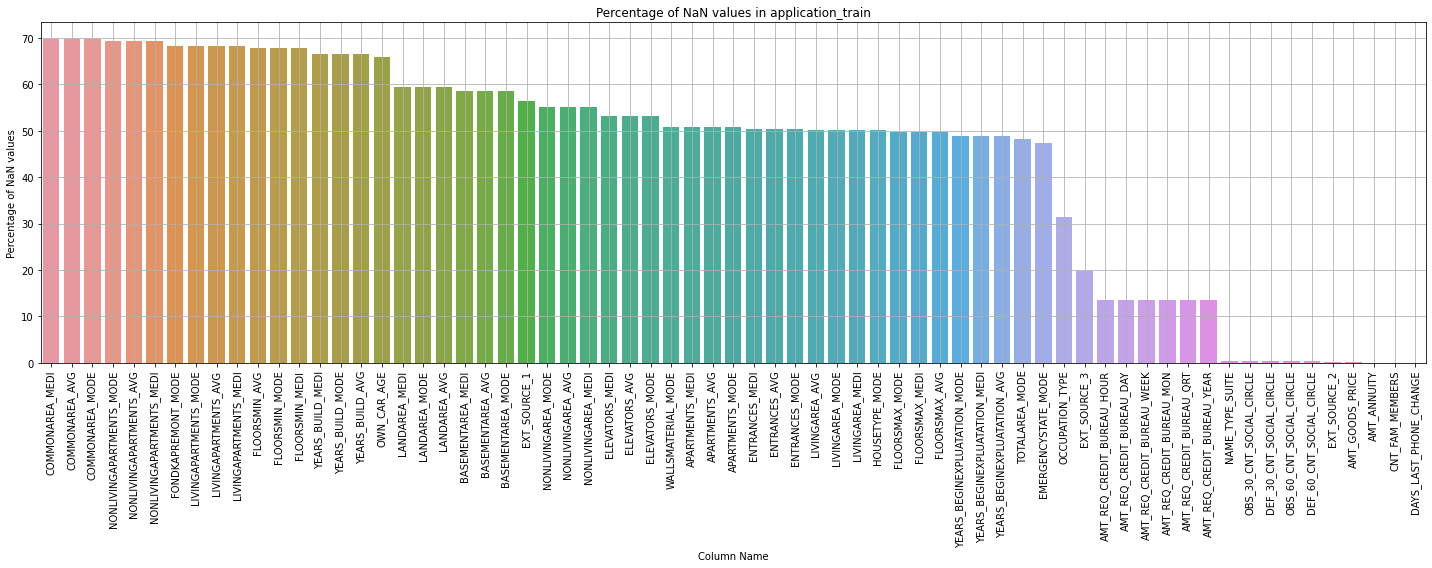

In [ ]:
plot_nan_percent(nan_df_create(train), 'application_train', grid = True)

Number of columns having NaN values: 64 columns


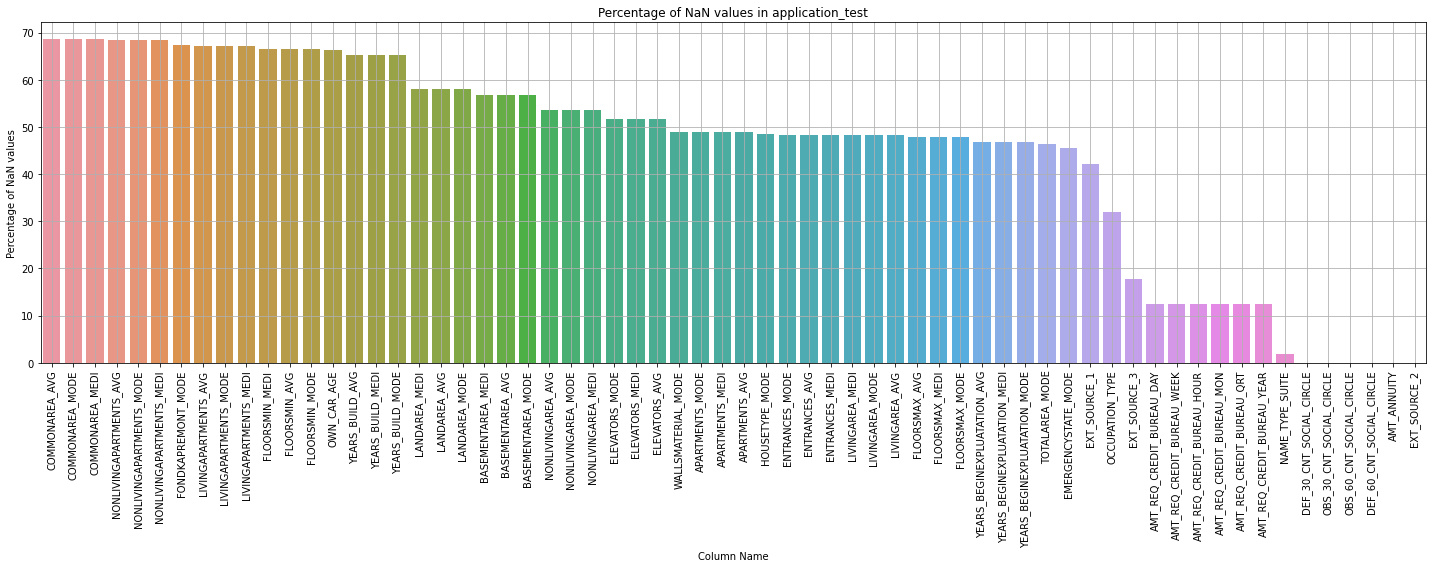

In [ ]:
plot_nan_percent(nan_df_create(test), 'application_test', grid = True)

**Observations and Conclusions:**
1. application_train.csv:
    - It can be seen from the above plot that there are 67 columns out of 122 features which contain NaN values. If there were just one or two columns which had NaN values, we could have gotten away with just eliminating those columns, but for such large number of columns, we cannot remove them as is, as loss of information could be very high.
    - We see that some columns like relating to "COMMONAREA", "NONLIVINGAPARTMENT", etc. have close to 70% missing values. We would have to come up with techniques to handle these many missing values and see what would work best for our data.
    - Another thing to note here is that most of the columns which have more than 50% missing values are related to the Apartments Statistics of the borrower. It is very likely that these values were not recorded during data entry, and could be optional.

2. application_test.csv:
    - There are very similar number of columns with NaN values (64) as were with the application_train.
    - The percentages of NaN values are also quite similar to the ones present in training dataset. This means that the training and test sets are pretty much of similar distribution.

## Distribution of Target Variable

In [ ]:
target_distribution = train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent+value' , pull = [0,0.04])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show()

**Observations and Conclusions:**
- From the distribution of Target variable, one thing that we can quickly notice is the Data Imbalance. There are only 8.07% of the total loans that had actually been Defaulted. This means that Defaulters is the minority class.
- On the other hand, there are 91.9% loans which were not Defaulted. Thus, Non-Defaulters will be our majority class.
- The Defaulters have been assigned a Target variable of 1 and Non-Defaulters have been assigned Target Variable 0.
- For imbalanced dataset, during building the model, we cannot feed the data as is to some algorithms, which are imbalance sensitive.
- Similar is the case with the Performance Metrics. For such a dataset, Accuracy is usually not the right metric as the Accuracy would generally be biased to majority class. We can use other metrics such as ROC-AUC Score, Log-Loss, F1-Score, Confusion Matrix for better evaluation of model.
- One more important thing to note here is that there are very few people who actually default, and they tend to show some sort of different behaviour. Thus in such cases of Fraud, Default and Anamoly Detection, we need to focus on outliers too, and we cannot remove them, as they could be the differentiating factor between Defaulter and Non-Defaulter.

## Phi-K matrix

We will plot a heatmap of the values of Phi-K Correlation Coefficient between each of the feature with the other. 
The Phi-K coefficient is similar to Correlation Coefficient except that it can be used with a pair of categorical features to check if one feature shows some sort of association with the other categorical feature. It's max value can be 1 which would show a maximum association between two categorical variables.

----------------------------------------------------------------------------------------------------


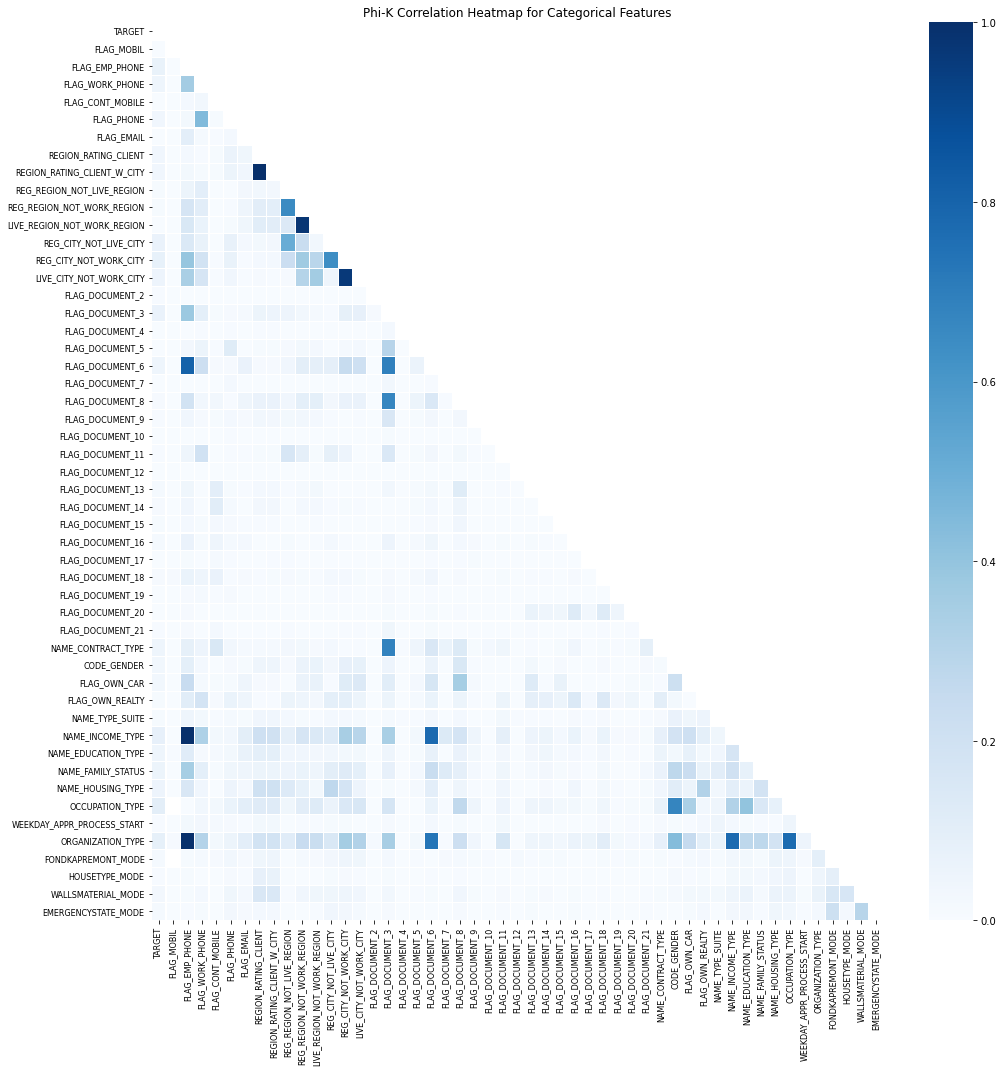

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.102846
45,ORGANIZATION_TYPE,0.089164
39,NAME_INCOME_TYPE,0.084831
12,REG_CITY_NOT_WORK_CITY,0.079946
1,FLAG_EMP_PHONE,0.072087
11,REG_CITY_NOT_LIVE_CITY,0.069588
15,FLAG_DOCUMENT_3,0.069525
41,NAME_FAMILY_STATUS,0.056043
42,NAME_HOUSING_TYPE,0.051107
13,LIVE_CITY_NOT_WORK_CITY,0.050956


----------------------------------------------------------------------------------------------------


In [ ]:
cats = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + train.dtypes[
                                    train.dtypes == 'object'].index.tolist()
plot_phik_matrix(train, cats, figsize = (15,15), fontsize = 8)

**Observations and Conclusions:**
1. From the above heatmap of Phi-K Correlation, we see that most of the categorical features are not correlated to each other, however some of them show strong correlation.
2. Some of the highly correlated Category pairs are:
    - REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT - This is understandable as they would more or less tell a similar story.
    - LIVE_REGION_NOT_WORK_REGION and REG_REGION_NOT_WORK_REGION
    - NAME_INCOME_TYPE, ORGANIZATION_TYPE and FLAG_EMP_PHONE
3. We can also see some correlation between the Organization type and the income type of a client. Similarly we see a correlation between the Occupation Type and the Organization Type too.
4. We find that the category OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY are some of the highest correlated categories with the TARGET variable. These maybe important in the classification task, and would need further EDA

## Correlation Matrix of Features

We will plot a heatmap of the correlation of each numeric feature with respect to other features. We have excluded the column SK_ID_CURR, as it does not have any relevance. This heatmap will help us identify the highly correlated numeric features and will also help us to identify features which are highly correlated with Target Variable.

----------------------------------------------------------------------------------------------------


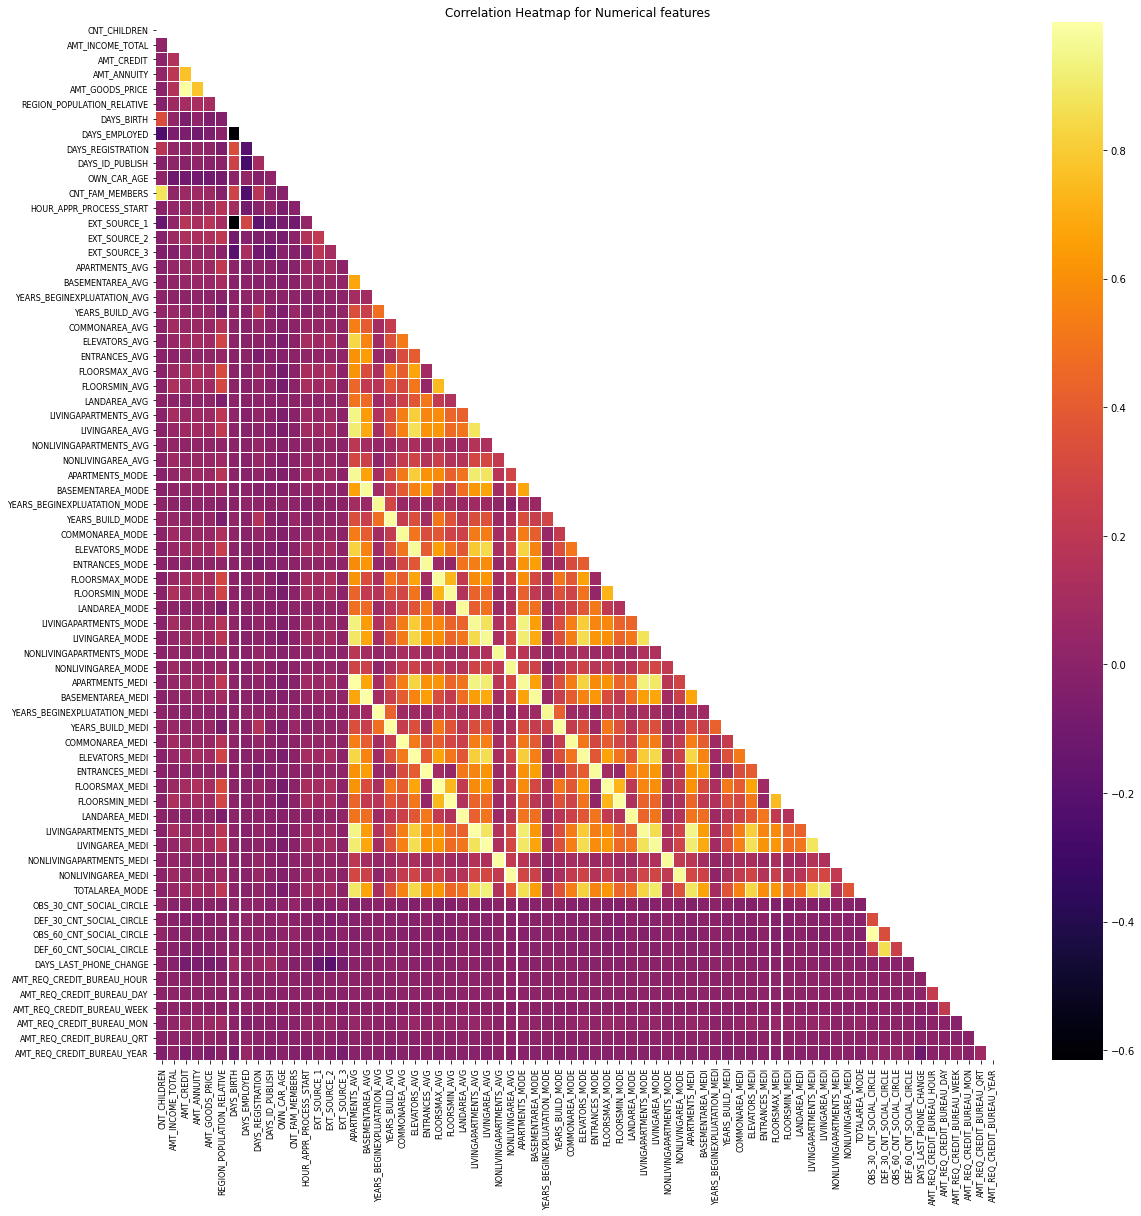

----------------------------------------------------------------------------------------------------


In [ ]:
drop = ['SK_ID_CURR'] + list(set(cats) - set(['TARGET']))
corr_mat = correlation_matrix(train, drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [ ]:
#Seeing the top columns with highest phik-correlation with the target variable in application_train table

top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.247680
13,EXT_SOURCE_1,0.217846
14,EXT_SOURCE_2,0.213965
6,DAYS_BIRTH,0.102378
63,DAYS_LAST_PHONE_CHANGE,0.073218
7,DAYS_EMPLOYED,0.072095
9,DAYS_ID_PUBLISH,0.067766
4,AMT_GOODS_PRICE,0.059094
23,FLOORSMAX_AVG,0.058826
51,FLOORSMAX_MEDI,0.058595


----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------------------------------------

**Observations and Conclusions:**
1. The heatmap does a good job of showing the value or level of correlation that each particular feature has with all other features.
2. It can be observed that most of the heatmap contains a purple-ish color, which indicates a very small value of correlation. This implies that most of the features are indeed not correlated to others.
3. However, we can see contrasting shades at the middle of the heatmap. These shades depict a high value of correlation between the features. These are the features which are related to the stats of the apartments.
If we look at the features of application_train, we can clearly see that the statistics of apartments are given in terms of Mean, Median and Mode, so it can be expected for the mean, median and mode to be correlated with each other. One more thing to note is that the features among particular category, for example Mean are also correlated with other mean features, such as Number of Elevators, Living Area, Non-Living Area, Basement Area, etc.
4. We also see some high correlation between AMT_GOODS_PRICE and AMT_CREDIT, between DAYS_EMPLOYED and DAYS_BIRTH.
5. We would not want highly correlated features as they increase the time complexity of the model without adding much value to it. Hence, we would be removing the inter-correlated features.
6. Among all the features, we see some high correlation for EXT_SOURCE features with respect to Target Variable. These might be important for our classification task.

## Plotting Categorical Variables

### Distribution of Categorical Variable NAME_CONTRACT_TYPE

This column contains information about the type of loan for the given applicant. As per the documentation provided by Home Credit, there are two types of loans, i.e. Revolving Loans and Cash Loans.

In [ ]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(train, 'NAME_CONTRACT_TYPE')

#plotting the Pie Plot for the column
plot_categorical_variables_pie(train, 'NAME_CONTRACT_TYPE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
From the above plot, we can draw following observations and conclusions:

1. From the first subplot, i.e. the overall distribution:
    - It can be seen that most of the loans that the customers take are Cash Loans.
    - Only 9.52% of the people have taken Revolving Loans.
2. From the second subplot, i.e. Percentage of Defaulters:
    - We see is that there are more percentage of people who have defaulted with Cash Loans (8.35%) as compared to those who defaulted with Revolving Loans (5.48%).

### Distribution of Categorical Variable CODE_GENDER

This column contains information about the Gender of the Client/Applicant.
Here M stands for Male and F for Female.

In [ ]:
#let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(train, 'CODE_GENDER', show_counts = True)

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(train, 'CODE_GENDER', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
The Distribution of CODE_GENDER feature seems interesting. Here are some talking points:

1. First point to observe is that there are 4 rows in the application_train table which have 'XNA' genders, which dont make much sense, and can be counted as NaN values. Since they are only 4 in Number and only belong to Non-Defaulter Category. So, we can eliminate those rows without much hesitation.
2. From the subplot 1 we see that for the given dataset, there are more number of Female applicants (65.8%) than Male applicants (34.2%).
3. However, contrary to the number of Female applicants, from the second plot we note that it has been seen that Male applicants tend to default more (10.14%) as compared to Female applicants (7%).
Thus, it can be said that Male have more tendency to default than Female as per the given dataset.

### Distribution of Categorical Variable FLAG_EMP_PHONE

This column is a boolean column, which tells whether if the client provided his Work Phone Number or not.
Here 1 stands for Yes and 0 stands for No.

In [ ]:
#let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(train, 'FLAG_EMP_PHONE')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
This feature contains two categories, i.e. if the client had provided his Work Phone Number during registration/application process or not.

1.From the first subplot we see that most of the applicants do not provide their Work Phone Number (82%) and only 18% have provided their Work Phone Number.
2. It can also be seen that the Default tendency for those who do provide Work Phone Number is more than those who do not provide Work Phone Number.
This is characteristic could be attributed to the fact that the Defaulters might be providing their Work Phone Numbers so that they don't get disturbed on their personal phone.

### Distribution of Categorical Variable REGION_RATING_CLIENT_W_CITY

This feature is the rating provided by the Home Credit to each client's region based on the surveys that they might have done. This rating also takes into account the City in which the client lives. 
Taking City into account is important because even if some regions have a good rating in a particular City, but that City doesn't have high rating, then applicant would be given a medium rating and not a high rating.
It contains values in the range from 1 to 3.

In [ ]:
#let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(train, column_name = 'REGION_RATING_CLIENT_W_CITY')
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
From the above plots, we can draw following insights:

1. From the first subplot, we see that most of the clients (74.6%) have a region rating of 2. This is the middle value which is for most of the applicants.
Very few applicants have a region rating of 1 (only 11.1%) and some have a rating of 3 (14.3%).
2. Among the Defaulters, it is seen that most of the defaulters have a region rating of 3 (11.4%) which is comparably higher to the other two ratings, i.e. clients with rating of 1 have a Defaulting percentage of just 4.84% and with rating 2 have a percentage of 7.92%.


This shows that the rating 3 could be an important attribute for making a decision on Defaulting Characteristics.

### Distribution of Categorical Variable NAME_EDUCATION_TYPE

This feature descibes/enlists the Highest Education that the client had achieved.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


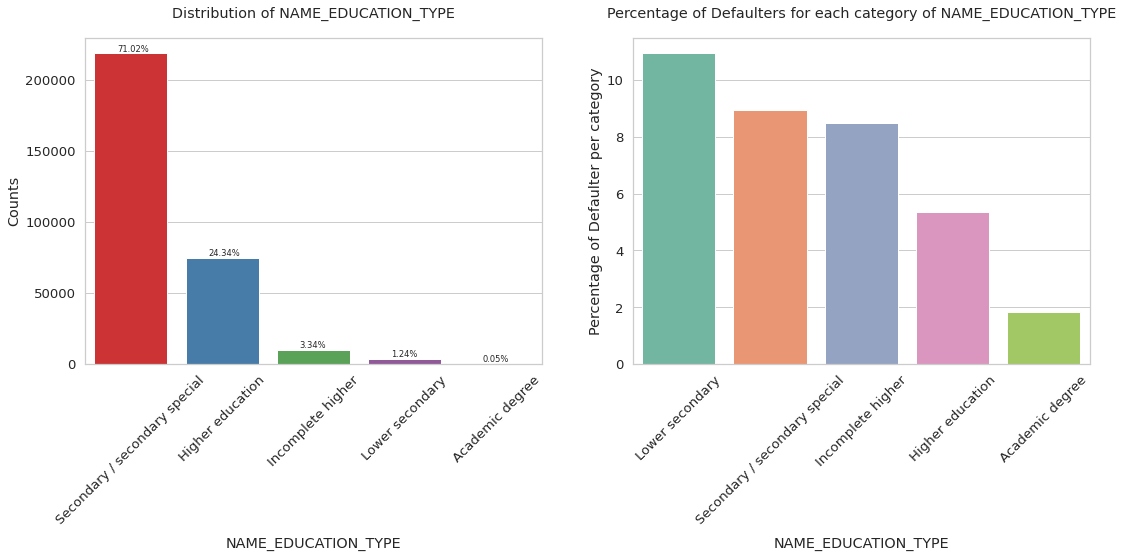

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)
print('-'*100)

**Observations and Conclusions:**
Looking at the above plots, we can conclude the following:

1. About 71% of people have had their education only till Secondary/Secondary Special, along with 24.34% clients having done Higher Education. This suggests that most of the clients/borrowers don't have a high education level.
2. From the second plot, we see that the people who have had their studies till only Lower Secondary have the highest Defaulting Characterists, with Secondary and Incomplete higher having similar defaulting tendencies.
3. The group of people with Higher Education have comparably lower defaulting tendency, which is logical too. Also, people with Academic Degree show the least Defaulting Rate. However, the Academic Degree group are very few in numbers, so it might not be very useful.

### Distribution of Categorical Variable OCCUPATION_TYPE

This feature tells about the type of Occupation that the client has. This can be a very important feature which could describe the Defaulting Characteristics of a client. Let us see the plots for them.

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


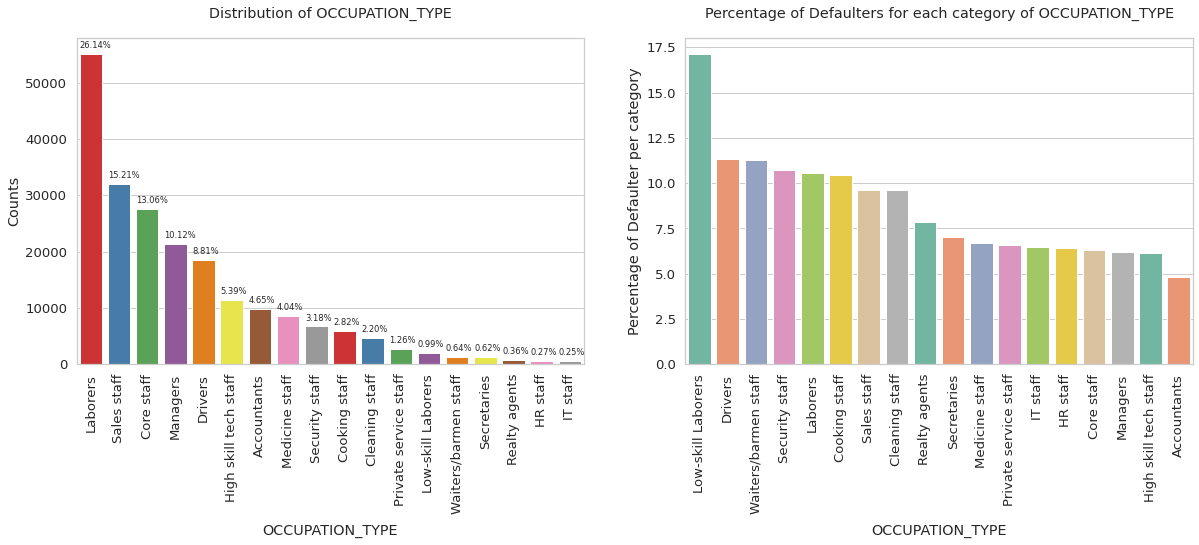

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

**Observations and Conclusions:**
From the plots of Occupation Type, we can draw following observations:

1. Among the applicants, the most common type of Occupation is Laborers contributing to close to 26% applications. The next most frequent occupation is Sales Staff, followed by Core Staff and Managers.
2. The Defaulting Rate for Low-Skill Laborers is the highest among all the occupation types (~17.5%). This is followed by Drivers, Waiters, Security Staff, Laborers, Cooking Staff, etc. All the jobs are low-level jobs. This shows that low-level Jobs people tend to have higher default rate.
3. The lowest Defaulting Rate are among Accountants, Core Staff, Managers, High skill tech staff, HR staff, etc. which are from medium to high level jobs.
Thus it can be concluded that Low-level job workers tend to have a higher defaulting tendency compared to medium-high level jobs.

### Distribution of Categorical Variable ORGANIZATION_TYPE

Similar to Occupation Type, Organization Type that the client belongs to could also be an important feature for predicting the Default Risk of that client. Let us visualize this feature in more detail.

Total Number of categories of ORGANIZATION_TYPE = 58


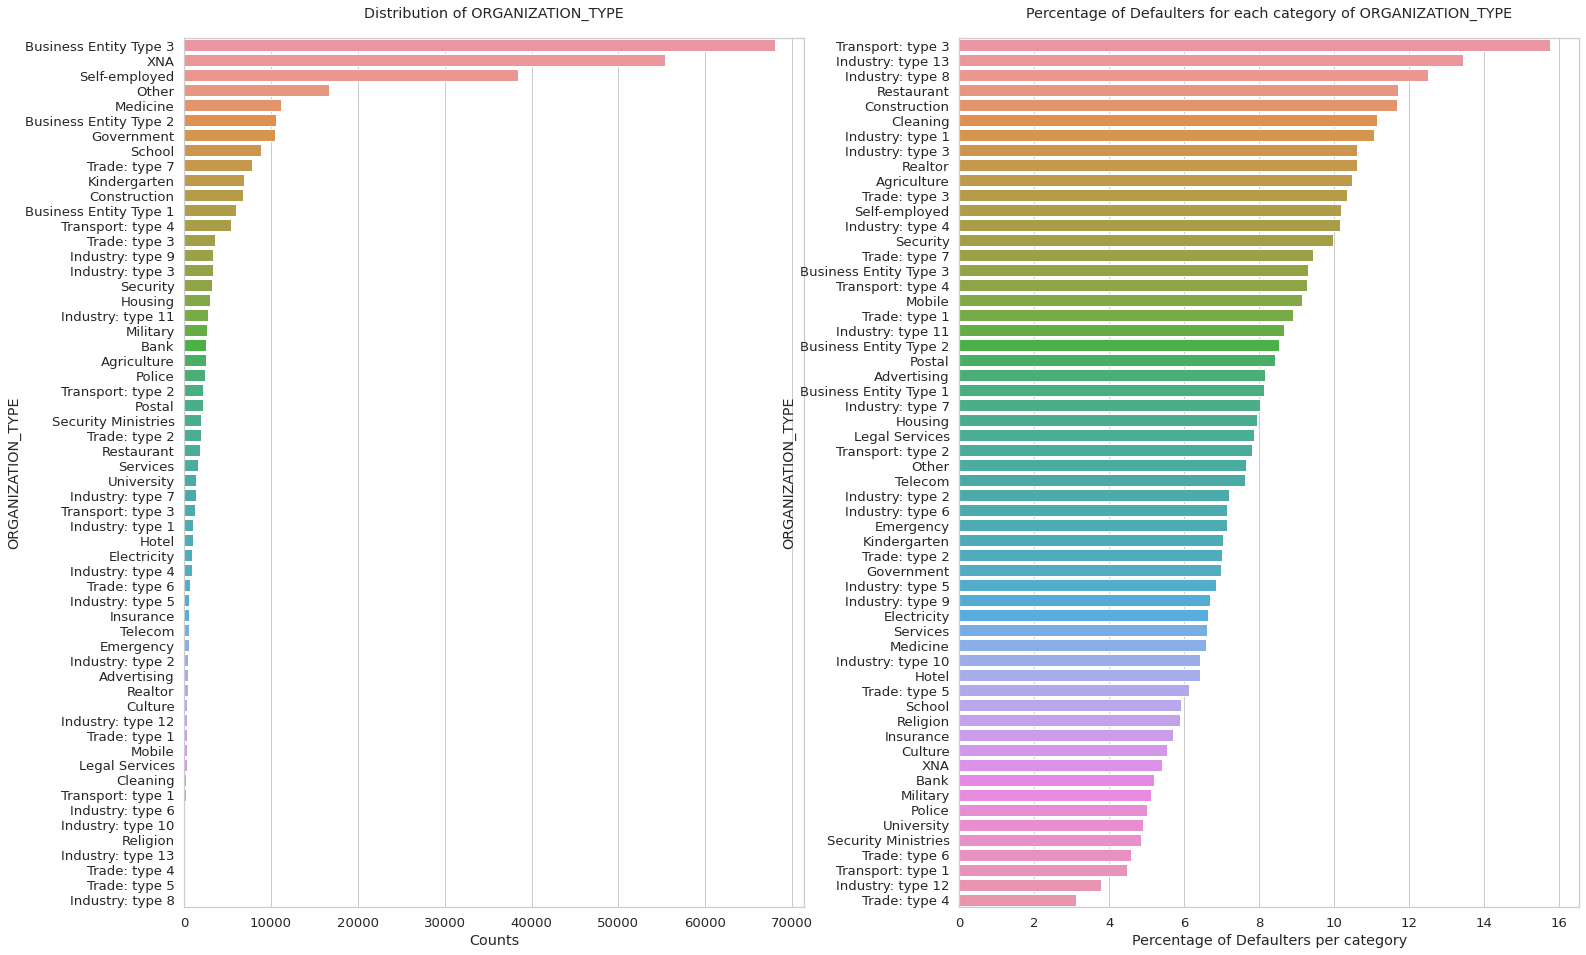

In [ ]:
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize = (25,16))
sns.set(style = 'whitegrid', font_scale = 1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
count_organization = train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
sns.barplot(x = count_organization, y = count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1,2,2)
percentage_default_per_organization = train[train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
sns.barplot(x = percentage_default_per_organization, y = percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()

**Observations and Conclusions:**
There are a lots of organization types which the client belongs to, 58 to be precise. The plots above give the following observations:

1. From the first plot we see that most of the applicants work in Organizations of Type 'Business Entity Type 3', 'XNA' or 'Self Employed'. The Organization Type 'XNA' could probably denote unclassified Organization TYpe.
2. From the second plot, we notice that the applicants belonging to 'Transport: type 3' have the highest defaulting tendency as compared to the rest. They are followed by organizations of types: 'Industry: type 13', 'Industry: type 8', 'Restaurant', 'Construction', etc.
3. The organizations which show lowest default rates are 'Trade: type 4', 'Industry: type 12', etc.


These type numbers also would say something more about the Organization, however, we don't have any information related to that, so we will stick with the naming provided to us only.

### Distribution of Categorical Variable REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY 

REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY:
These columns include flags whether if the the client's permanent address matches with his Contact Address or Work Address or not at region level 

LIVE_CITY_NOT_WORK_CITY This column indicates whether if the client's permanent address matches with his Contact Address at city level or not.

Here 1 indicates different addresses and 0 indicates same addresses.

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


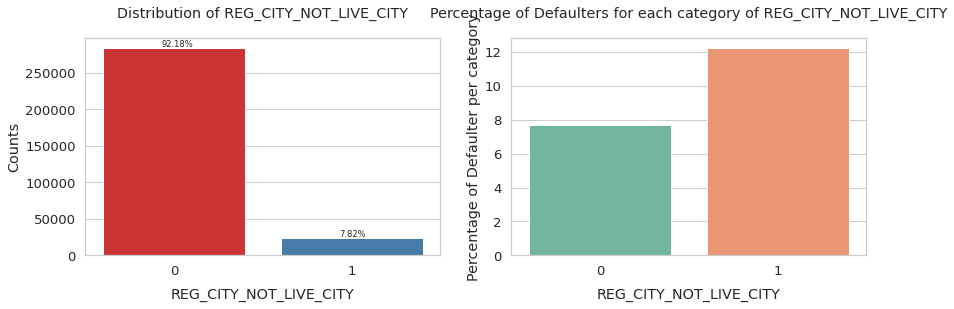

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


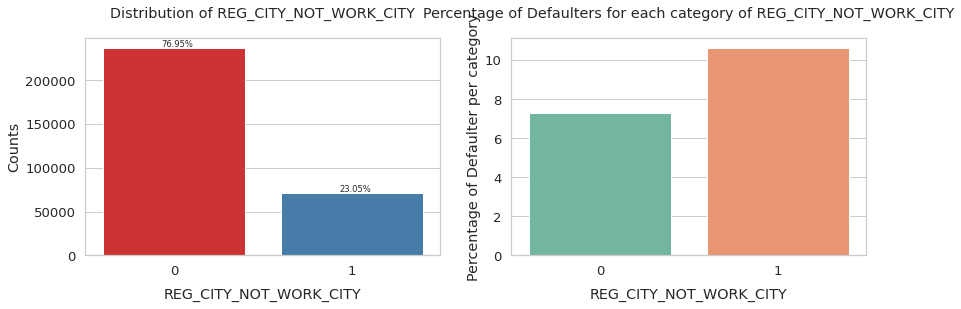

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


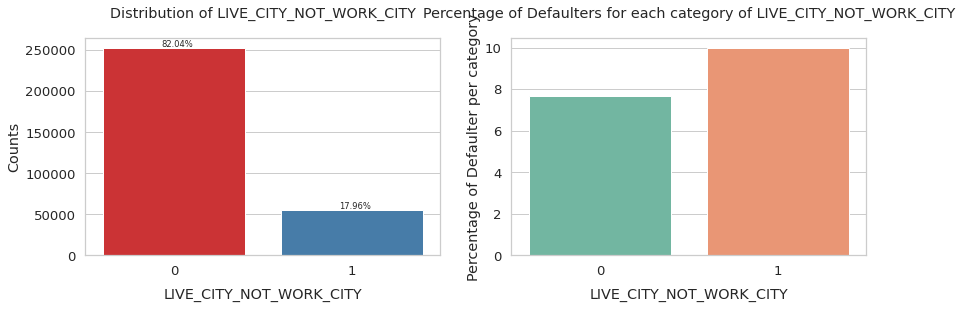

----------------------------------------------------------------------------------------------------


In [ ]:
print('-'*100)
plot_categorical_variables_bar(train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

**Observations and Conclusions:**
From the above 3 plots, following insights can be drawn:

1. Of all the applicants there are only a minority of applicants whose addresses do not match.
    - Firstly, there are only 7.52% people who have different permanent address from their contact address at region level.
    - Secondly, there are around 23.05% people who have different permanent address from their work address at region level. This higher number is explainable, because it is possible that they work in different region as compared to their permanent address.
    - Lastly, there are around 17.96% people who have different permanent address from their contact address at city level.
2. If we look at the defaulting characteristics, we find that there is maximum defaulting tendency of those people who have their permanent and contact addresses different at region level, which is followed by different permanent and work address and lastly different permanent and contact address at city level.
    - For all the cases it is seen that the Defaulting tendency of those people who have different addresses is higher than those who have same address. This means that somewhere, this difference in address may suggest Defaulting Risk.

### Distribution of Categorical Variables FLAG_DOCUMENT_3

This columns contains the flag about a document that was to be submitted by the applicant. It's value is 0 if the client had provided the document and 1 if not.

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


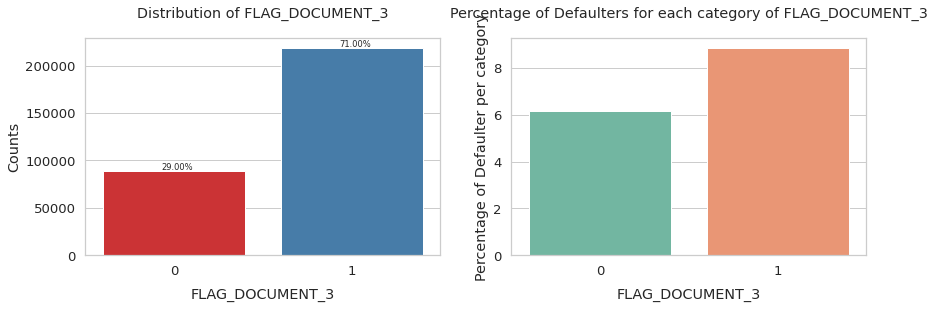

In [ ]:
plot_categorical_variables_bar(train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

**Observations and Conclusions:**
From the above plot, we see that:

1. From the first subplot, we see that most of the clients hadn't provided this document (~71%) and only 29% did.
2. From the second subplot, we see that those who had provided this document had a higher defaulting rate than those who didn't. This means that the applicants who had provided the Document_3 tend to default more than those who don't.
3. Perhaps this could be something related to BPL certificate or something, but we haven't been provided with that information, so we cannot say anything about the kind of document it could have been.

## Plotting Continuous Variables

### Distribution of Continuous Variable Age of Applicant

For the given dataset, the age is given in Days, which can be harder to interpret. Thus, we will create a latent variable to store the ages in Years, which would be easier to analyse and interpret.

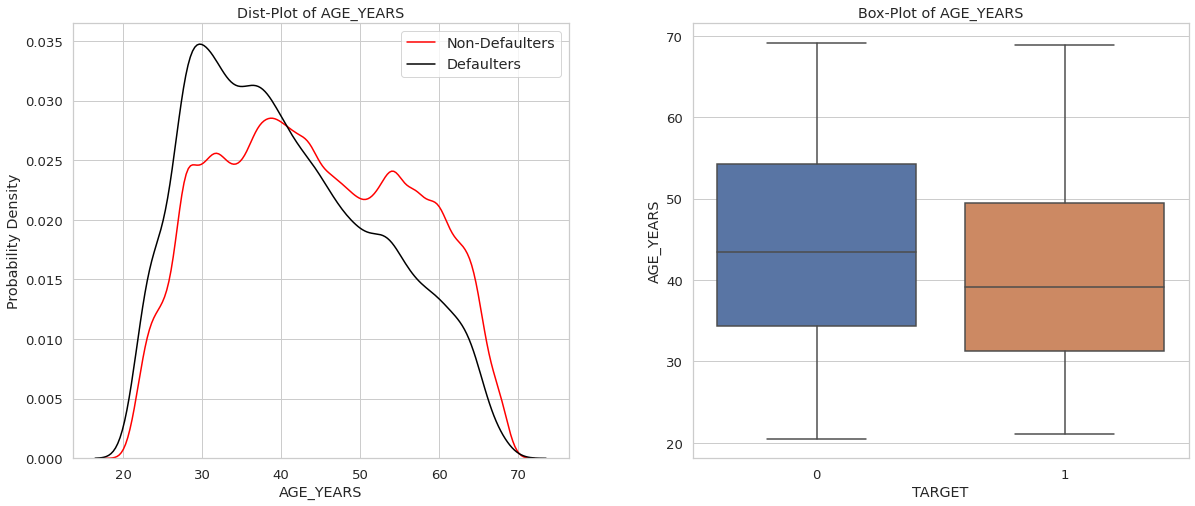

In [ ]:
train['AGE_YEARS'] = train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(train, 'AGE_YEARS', plots = ['distplot','box'])
_ = train.pop('AGE_YEARS')

**bservations and Conclusions:**
From the above two plots, we can draw some important insights.

1. From the distplot, we can observe the peak of Age of people who Default to be close to 30 years. Also, at this point, the Non-Defaulters have a quite smaller PDF. One more thing to note is that the PDF of Age for Defaulters starts a bit left from the Non-Defaulters, and also is a bit throughtout the range. This means that the Defaulters are usually younger than Non-Defaulters.
2. From CDF too we see that the probability
3. From the box-plot too, we can better visualize the same thing. The Age of Defaulters is usually lesser than the Non-Defaulters. All the quantiles of ages of Defaulters is lesser than Non-Defaulters. The 75th percentile value of Non-Defaulters is around 54 years while for Defaulters it is near to 49 years.
These observations imply that the Defaulters are usually younger than Non-Defaulters.

### Distribution of Continuous Variables with DAYS features

### DAYS_EMPLOYED

This feature tells about the number of days from the day of application the applicant had been employed. For easy interpretation, we will convert the days to years.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


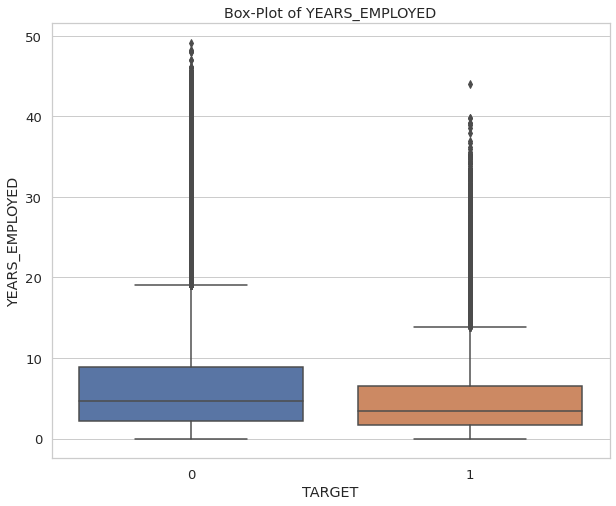

In [ ]:
train['YEARS_EMPLOYED'] = train.DAYS_EMPLOYED * -1 / 365
print_percentiles(train, 'DAYS_EMPLOYED')
plot_continuous_variables(train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = train.pop('YEARS_EMPLOYED')

**Observations and Conclusions:**
1. We see that the DAYS_EMPLOYED column contains some erroneous datapoints with values 365243. These seem like some erroneous/non-sensicle values.
2. From the box plot we observe that the Defaulters seem to have less number of years being employed as compared to Non-Defaulters. All the 25th, 50th and 75th quantile for Defaulters are lesser than those of Non-Defaulters.

### DAYS_ID_PUBLISH

This columns tells about how many days ago from the day of registration did the client change his Identity Document with which he applied for loan.

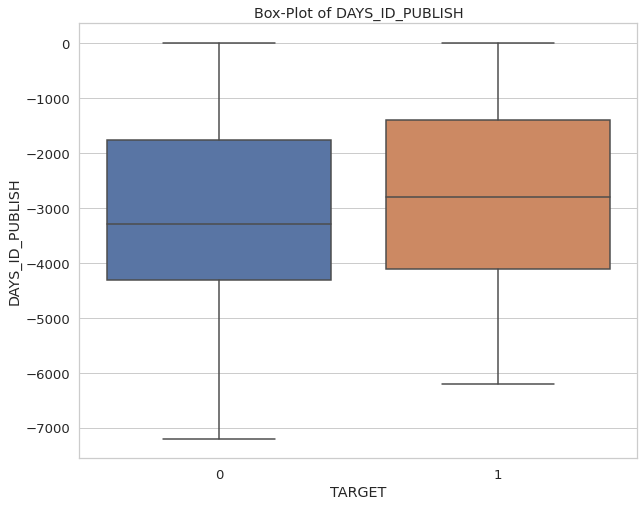

In [ ]:
plot_continuous_variables(train, 'DAYS_ID_PUBLISH', plots = ['box'], figsize = (10,8))

**Observations and Conclusions:**


From the above box plot, we see a similar trend as seen with DAYS_REGISTRATION, in which the Defaulters usually had lesser number of days since they changed their identity. The Non-Defaulters show to have more number of days for all the quantiles since they changed their identity document.

### Distribution of EXT_SOURCES

There are three EXT_SOURCES columns, which contain values between 0 and 1. They are normalized scores from different sources

----------------------------------------------------------------------------------------------------


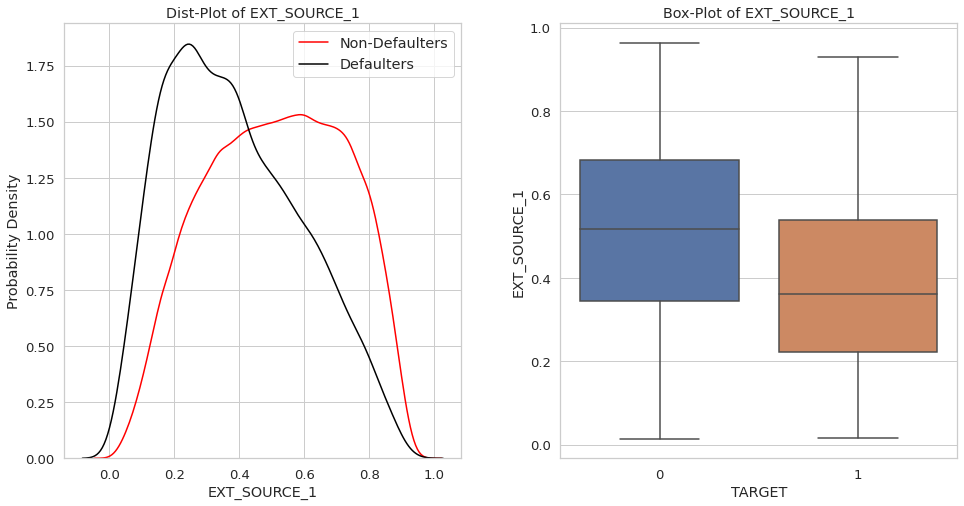

----------------------------------------------------------------------------------------------------


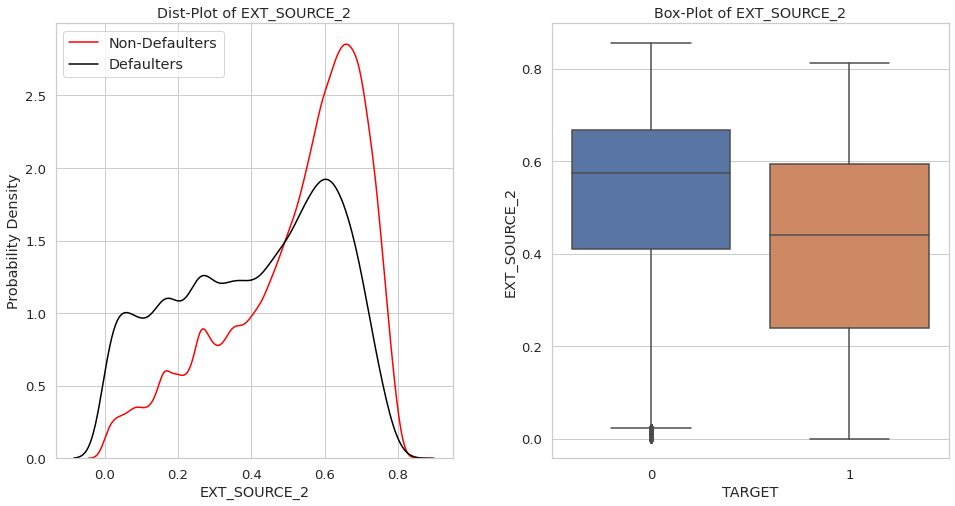

----------------------------------------------------------------------------------------------------


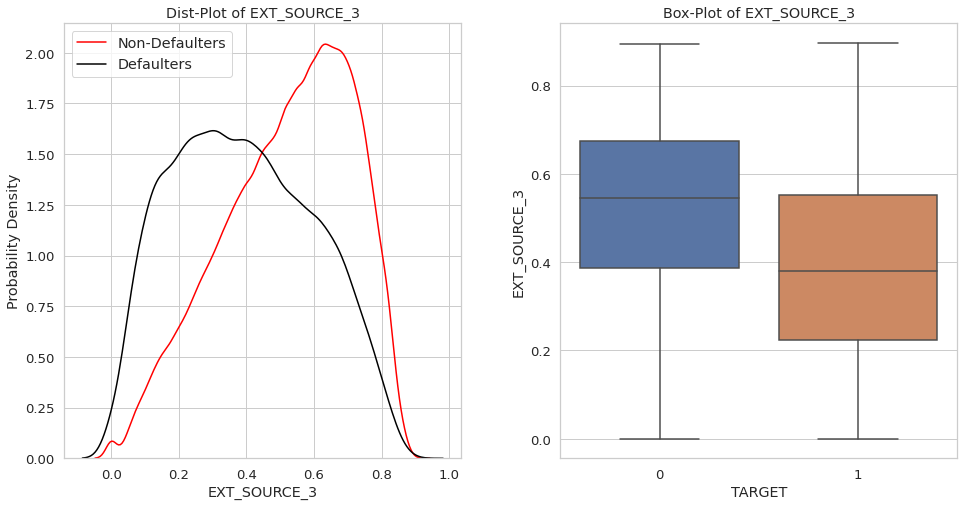

----------------------------------------------------------------------------------------------------


In [ ]:
print('-'*100)
plot_continuous_variables(train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)

**Observations and Conclusions:**
From the above three plots, we can draw following conclusions:

1. If we look at the box-plots, we can clearly see a similar trend for all three EXT_SOURCE columns, which is that the Defaulters tend to have considerably lower values.
2. This trend can also be seen with the PDFs. The Non-Defaulters show a higher peak at high EXT_SOURCE values, and the Probability Densities are very low for low values. This implies that Non-Defaulters generally have high values of these scores.
3. It is interesting to note that the median value for defaulters is almost equal to or lower than 25th percentile values of Non-Defaulters.
4. EXT_SOURCE_1 and EXT_SOURCE_3 columns tend to show better discrimination/separability as compared to EXT_SOURCE_2.
5. These 3 features look to be best separating the Defaulters and Non-Defaulters linearly among all the features so far.

### Distribution of FLOORSMAX_AVG and FLOORSMIN_MODE

These columns describe the normalized scores of Average of Maximum number of Floors and Mode of Minimum number of Floors in applicant's building

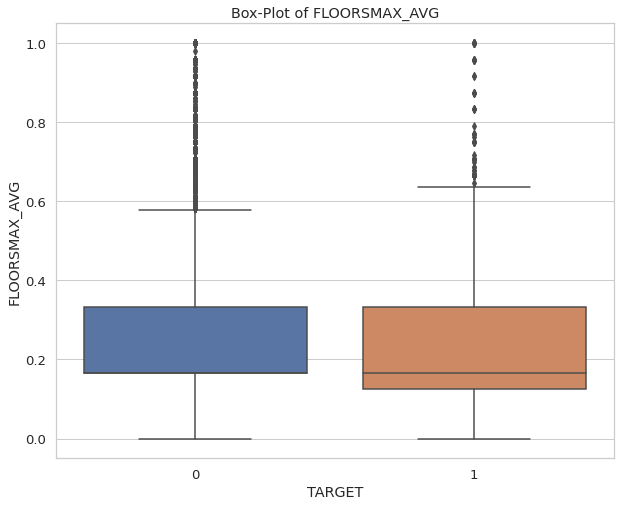

In [ ]:
plot_continuous_variables(train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (10,8))

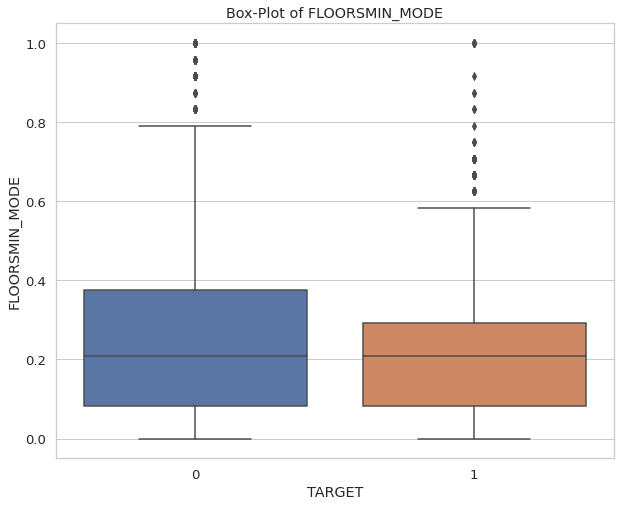

In [ ]:
plot_continuous_variables(train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (10,8))

**Observations and Conclusions**
From the above plot, we can draw the following insights:

1. The defaulters have lower median value of FLOORSMAX_AVG feature as compared to Non-Defaulters. The 75th percentile values of both the Defaulters and Non-Defaulters is more or less the same, but the 25th percentile value of Non-Defaulters is almost more than the median of Defaulters, thus this could be an important feature.
2. The Non-Defaulters also tend to show a higher value of FLLORSMIN_MODE as compared to Defaulters. The 75th percentile value of Non-Defaulters is significantly higher than the 75th percentile value of Defaulters.

# bureau

**Description**


This table consists of all client's previous credit records with financial institutions other than Home Credit Group which were reported by the the Credit Bureau.

In [ ]:

bureau = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/bureau.csv')
test = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/application_test.csv')

print(f'The shape of bureau.csv is: {bureau.shape}')
print('-'*100)
print(f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: {len(set(test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

The shape of bureau.csv is: (1716428, 17)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau.csv are: 1716428
Number of unique SK_ID_CURR in bureau.csv are: 305811
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: 42320
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


**Observations and Conclusions:**
1. The bureau.csv file contains close to 1.7M datapoints, with 17 features. Out of these 17 features, two are SK_ID_CURR and SK_ID_BUREAU.
    - SK_ID_BUREAU is the loan ID of the client's previous loan from other financial institutions. There may be multiple previous loans corresponding to a single - SK_ID_CURR which depends on client's borrowing pattern.
SK_ID_CURR is the loan ID of client's current loan with Home Credit.
    - The rest of the features contain other stats such as DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.
2. There are 305k unique SK_ID_CURR in bureau out of which:
    - There are 263k SK_ID_CURR in bureau which are present in application_train out of total of total 307k of application_train's unique SK_ID_CURR. This means that some of the applicants in current loan application with Home Credit Group do not have any previous Credit history with Credit Bureau Department.
    - Similarly, there are 42.3k SK_ID_CURR in bureau which are present in application_test, out of total 48k of application_test's unique SK_ID_CURR.


## NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 7 columns


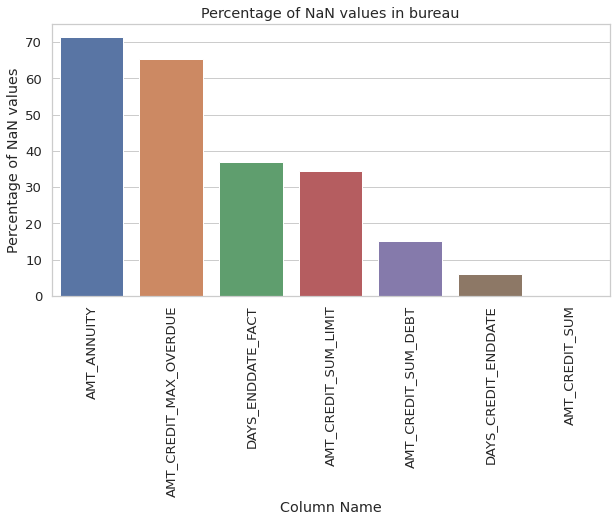

----------------------------------------------------------------------------------------------------


In [ ]:
nan_df_bureau = nan_df_create(bureau)
print("-"*100)
plot_nan_percent(nan_df_bureau, 'bureau', tight_layout = False, figsize = (10,5))
print('-'*100)

**Observations and Conclusions:**


Out of 17 features, there are 7 features which contain NaN values.
The highest NaN values are observed with the column AMT_ANNUITY which has over 70% missing values.

### Merging the TARGETS from application_train to bureau table.

In [ ]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------


## Phi-K Matrix

----------------------------------------------------------------------------------------------------


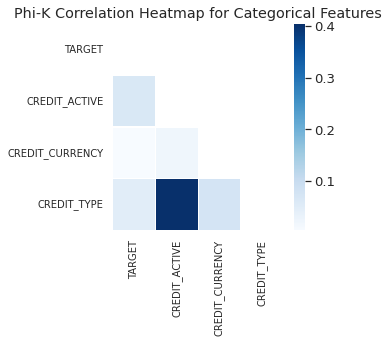

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
0,CREDIT_ACTIVE,0.064481
2,CREDIT_TYPE,0.049954
1,CREDIT_CURRENCY,0.004993


----------------------------------------------------------------------------------------------------


In [ ]:
cols_for_phik = ['TARGET','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize = (5,5))

**Observations and Conclusions:**

The above heatmap shows the Phi-K Correlation values between categorical values.

1. From the Phi-K Correlation Coefficient, we see that the variable CREDIT_TYPE shows some association with the variable CREDIT_ACTIVE.
2. We see that the Categorical Variables don't really have a high association with TARGET variable, especially the CREDIT_CURRENCY feature.

### Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


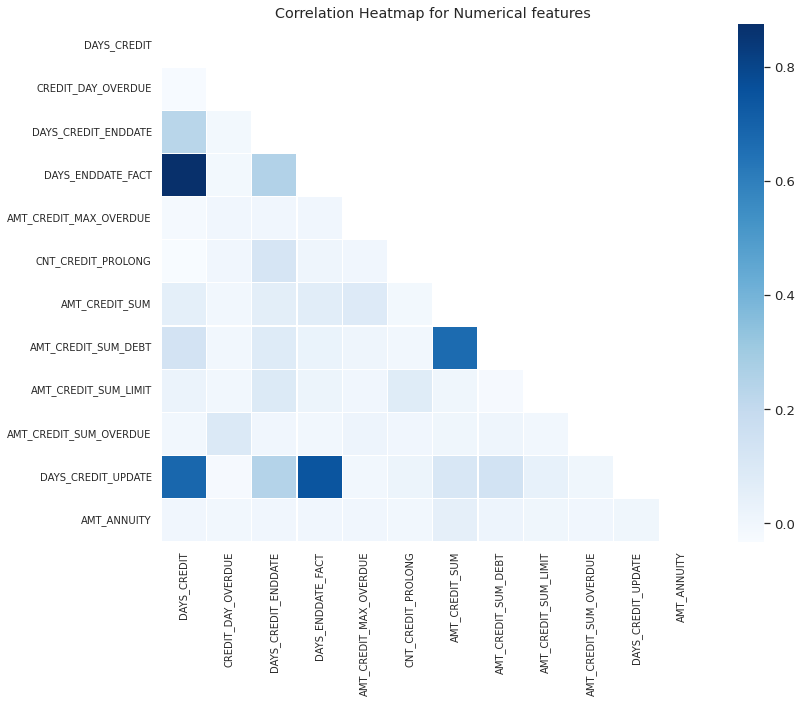

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(bureau_merged, ['SK_ID_CURR','SK_ID_BUREAU'], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

In [ ]:
#Seeing the top columns with highest phik-correlation with the target variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT']
interval columns not set, guessing: ['TARGET', 'CREDIT_DAY_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_ENDDATE']
interval columns not set, guessing: ['TARGET', 'DAYS_ENDDATE_FACT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_MAX_OVERDUE']
interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_DEBT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_LIMIT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_UPDATE']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
0,DAYS_CREDIT,0.088651
2,DAYS_CREDIT_ENDDATE,0.018980
9,AMT_CREDIT_SUM_OVERDUE,0.005654
8,AMT_CREDIT_SUM_LIMIT,0.005192
4,AMT_CREDIT_MAX_OVERDUE,0.004280
5,CNT_CREDIT_PROLONG,0.003862
1,CREDIT_DAY_OVERDUE,0.002528
10,DAYS_CREDIT_UPDATE,0.002219
7,AMT_CREDIT_SUM_DEBT,0.001695
6,AMT_CREDIT_SUM,0.000670


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
1. The heatmap above shows the correlation between each feature in bureau table with the rest of the features.
2. It can be observed that most of the heatmap has light colors, which shows little to no correlation.
3. However, we can see some dark shades which represent high correlation.
4. The high correlation is particularly observed for features:
    - DAYS_CREDIT and DAYS_CREDIT_UPDATE
    - DAYS_ENDDATE_FACT and - DAYS_CREDIT_UPDATE
    - AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT
    - DAYS_ENDDATE_FACT and DAYS_CREDIT
5. We can also see that the features don't particularly show good/high correlation with Target as such, except for DAYS_CREDIT feature. This implies that there isn't a direct linear relation between Target and the features.

###Plotting Categorical Variables
We will now plot some of the Categorical Variables of the table bureau, and see their impact on the Target Variable.

###Distribution of Categorical Variable CREDIT_ACTIVE

This column describes the Status of the previous loan reported from Credit Bureau.

----------------------------------------------------------------------------------------------------
The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CREDIT_ACTIVE = 5


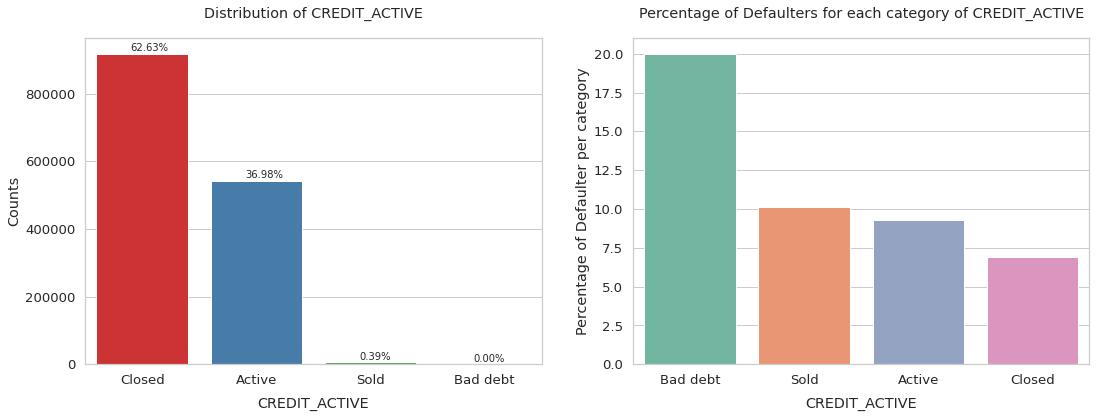

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(bureau_merged, column_name = 'CREDIT_ACTIVE', horizontal_adjust = 0.3, fontsize_percent = 'x-small')
print('-'*100)

**Observations and Conclusions:**


From the above plot, we can draw the following insights:

1. From the first subplot, we see that a majority of the previous loans from other financial institutions are Closed Loans (62.63%), followed by 36.98% active loans. The sold and Bad-Debt Loans are very less in number.
2. If we look at the Defaulters Percentage per category, we see that about 20% of people from Bad-Debt defaulted, which is the highest default rate. This is followed by Sold loans and Active Loans. The lowest default rate is for Closed Loans, which show a good history about a client. Thus the patten observed here is quite logical and expected.

###Plotting Continuous Variables

###Distribution of Continuous Variable with DAYS Features

DAYS_CREDIT

This column describes about the number of days before current application when the client applied for Credit Bureau Credit. For ease of interpretability, we will convert these days to years.

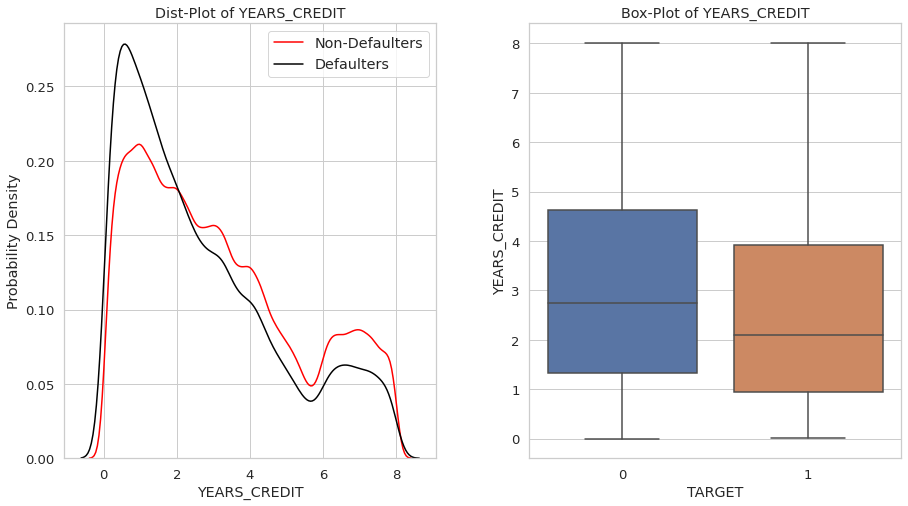

In [ ]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_merged.pop('YEARS_CREDIT')

**Observations and Conclusions:**

From the above plots, we see that:

1. From the PDF, we see that the Defaulters tend to have higher peaks compared to Non-Defaulters when the number of years are less.. This implies that the applicants who had applied for loans from Credit Bureau recently showed more defaulting tendency than those who had applied long ago. The PDF of Defaulters is also a bit towards left as compared to Non-Defaulters.
2. From the box-plot as well, we see that Defaulters usually had less YEARS_CREDIT as compared to Non-Defaulters.

###DAYS_CREDIT_ENDDATE

This column tells about the remaining duration of Credit Bureau credit at the time of application for loan in Home Credit.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2487.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2334.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2202.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2073.9199999999983
The 10th percentile value of DAYS_CREDIT_ENDDATE is -1939.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


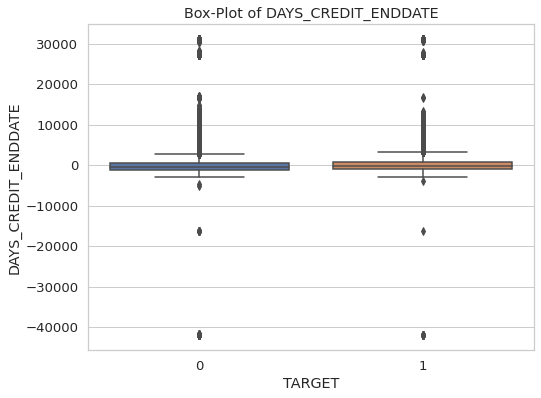

----------------------------------------------------------------------------------------------------


In [ ]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))
print('-'*100)

**Observations and Conclusions:**


From the above percentile values, and looking at the box-plot, we see that there seems to be erroneous value for DAYS_CREDIT_ENDDATE, where the 0th percentile value dates back to as long as 42060 days or 115 years. This does not make much sense as this implies that the previous loan the client had dates back to 115 years ago. This could be inherited loan too, but we cannot comment so surely about that. We would try to remove these values in the data preprocessing stage.

###DAYS_ENDDATE_FACT

This column tells about the the number of days ago that the Credit Bureau credit had ended at the time of application for loan in Home Credit. These values are only for Closed Credits.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 2th percentile value of DAYS_ENDDATE_FACT is -2561.0
The 4th percentile value of DAYS_ENDDATE_FACT is -2450.0
The 6th percentile value of DAYS_ENDDATE_FACT is -2351.0
The 8th percentile value of DAYS_ENDDATE_FACT is -2265.0
The 10th percentile value of DAYS_ENDDATE_FACT is -2173.0
The 25th percentile value of DAYS_ENDDATE_FACT is -1503.0
The 50th percentile value of DAYS_ENDDATE_FACT is -900.0
The 75th percentile value of DAYS_ENDDATE_FACT is -427.0
The 100th percentile value of DAYS_ENDDATE_FACT is 0.0
----------------------------------------------------------------------------------------------------


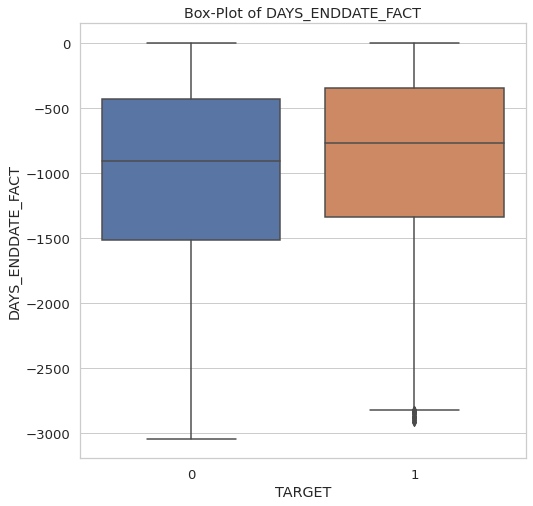

----------------------------------------------------------------------------------------------------


In [ ]:
print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])
print('-'*100)

**Observations and Conclusions:**
1. Just like previous column, we see that the 0th percentile for this column also seems erroneous, which is 42023 days or ~115 years. We would have to remove these values, as they don't make much sense.
2. Looking at the box-plot, we see that the Defaulters tend to have lesser number of days since their Credit Bureau credit had ended. The Non-Defaulters usually have their previous credits ended longer before than Defaulters.

###DAYS_CREDIT_UPDATE

This column tells about the the number of days ago that the information from Credit Bureau credit had come at the time of application for loan in Home Credit.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 2th percentile value of DAYS_CREDIT_UPDATE is -2415.0
The 4th percentile value of DAYS_CREDIT_UPDATE is -2213.0
The 6th percentile value of DAYS_CREDIT_UPDATE is -2002.0
The 8th percentile value of DAYS_CREDIT_UPDATE is -1766.0
The 10th percentile value of DAYS_CREDIT_UPDATE is -1582.0
The 25th percentile value of DAYS_CREDIT_UPDATE is -904.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -406.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -33.0
The 100th percentile value of DAYS_CREDIT_UPDATE is 372.0
----------------------------------------------------------------------------------------------------


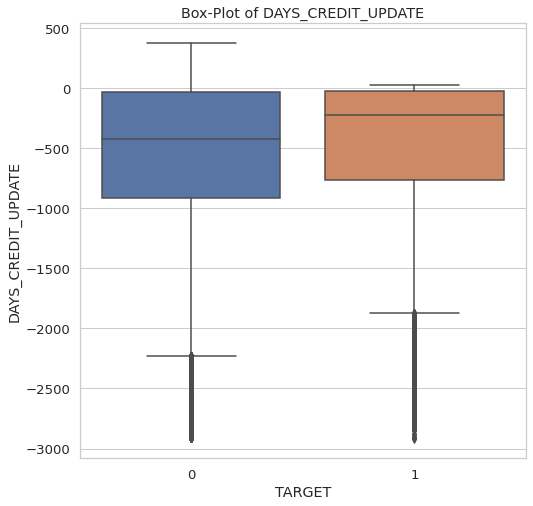

----------------------------------------------------------------------------------------------------


In [ ]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)

**Observations and Conclusions:**
1. he trend of erroneious values is again very similar to the other days column where this 0th percentile value seems to be erroneous. Also since only the 0th percentile value is so odd, and the rest seem to be fine, thus this value is definitely erroneous. We will be removing this value too.
2. From the box-plot, we can say that the Defaulters tend to have a lesser number of days since their Information about the Credit Bureau Credit were received. Their median, 75th percentile values all are lesser than those for Non-Defaulters.

#bureau_balance.csv

###Description

This table consists of Monthly balance of each credit for each of the previous credit that the client had with financial institutions other than Home Credit.

In [ ]:

bureau_balance = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/bureau_balance.csv')


print(f'The shape of bureau_balance.csv is: {bureau_balance.shape}')
print('-'*100)
print(f'Number of duplicate values in bureau_balance: {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')
print('-'*100)
display(bureau_balance.head(5))

The shape of bureau_balance.csv is: (27299925, 3)
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
print("-"*100)
print(f'Number of unique SK_ID_BUREAU in bureau_balance.csv are: {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*100)
print(f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")
print('-'*100)
print(f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau_balance.csv are: 817395
----------------------------------------------------------------------------------------------------
Number of unique values for STATUS are: 8
Unique values of STATUS are:
['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------
Max number of months for Months Balance: 96
----------------------------------------------------------------------------------------------------


**Observations and Conclusions**
1. The bureau_balance.csv table contains approximately 27.29M rows, and 3 columns.
2. This table contains the monthly status for each of the previous loan for a particular applicant reported by the Credit Bureau Department.
3. There are 8 unique values for the STATUS which are encoded. Each of them have a special meaning. 
C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off.
4. The most earliest month's balance that we have is the 96 months back status, i.e. the Status has been provided upto 8 years of history for loans for which those exist.

## NaN Columns and Percentages

In [ ]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance')

The dataframe bureau_balance does not contain any NaN values.


# previous_application.csv

###Description

This table contains the static data of the previous loan which the client had with Home Credit.

In [ ]:

prev = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/previous_application.csv')

print(f'The shape of previous_application.csv is: {prev.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in previous_application.csv are: {len(prev.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in previous_application.csv are: {len(prev.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(prev.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(test.SK_ID_CURR.unique()).intersection(set(prev.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in previous_application: {prev.shape[0] - prev.duplicated().shape[0]}')
print('-'*100)
display(prev.head(5))

The shape of previous_application.csv is: (1670214, 37)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in previous_application.csv are: 1670214
Number of unique SK_ID_CURR in previous_application.csv are: 338857
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 291057
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 47800
----------------------------------------------------------------------------------------------------
Number of duplicate values in previous_application: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**Observations and Conclusions:**
1. The table previous_application.csv consists of 1.67M rows in total. Each row corresponds to each of the previous loan that the client had with previously with Home Credit Group. It is possible for a single client of current application to have multiple previous loans with Home Credit Group.
2. There are 37 columns in previous_application.csv, which contain the details about the previous loan.
3. There are 338k unique SK_ID_CURR in previous_application, of which 291k correspond to the application_train SK_ID_CURRs and 47.8k correspond to application_test SK_ID_CURRs.

## NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 16 columns


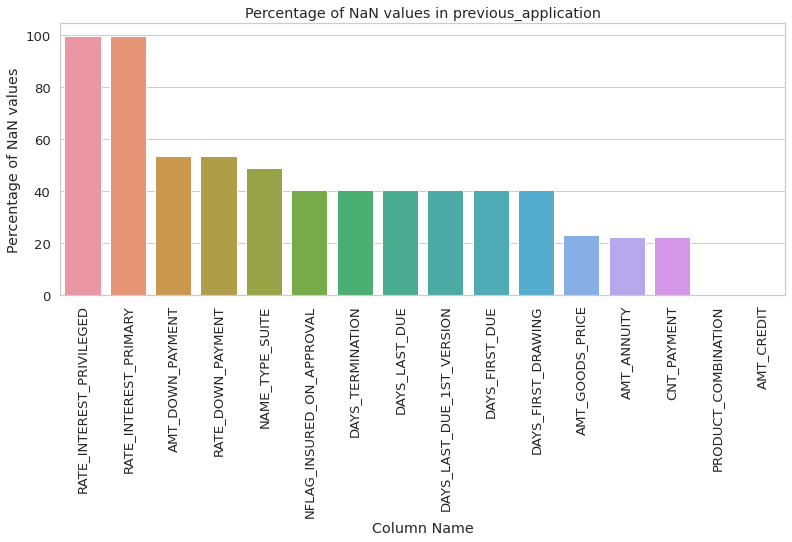

----------------------------------------------------------------------------------------------------


In [ ]:
prev_nan = nan_df_create(prev)
print('-' * 100)
plot_nan_percent(prev_nan, 'previous_application', tight_layout = False, figsize = (13,5))
print('-' * 100)
del prev_nan

**Observations and Conclusions**
1. There are 16 columns out of the 37 columns which contain NaN values.
2. Two of these columns have 99.64% missing values, which is very high, and we will have to come up with some smart way to handle such high NaN values. We cannot directly discard any feature at this point.
3. Other than these two columns, rest of the columns also contain > 40% NaN values, except for 5 columns.

### Merging the TARGETS from application_train to previous_application table

In [ ]:
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = train.iloc[:,:2].merge(prev, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


### Phi-K Matrix

----------------------------------------------------------------------------------------------------


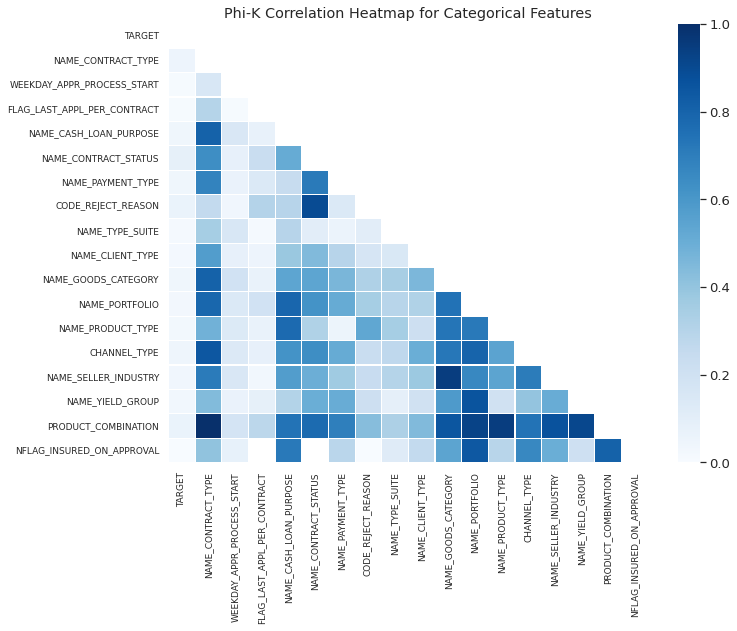

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
4,NAME_CONTRACT_STATUS,0.088266
15,PRODUCT_COMBINATION,0.063839
6,CODE_REJECT_REASON,0.062771
0,NAME_CONTRACT_TYPE,0.050859
12,CHANNEL_TYPE,0.050302
9,NAME_GOODS_CATEGORY,0.042951
3,NAME_CASH_LOAN_PURPOSE,0.040305
5,NAME_PAYMENT_TYPE,0.039752
13,NAME_SELLER_INDUSTRY,0.038077
14,NAME_YIELD_GROUP,0.034626


----------------------------------------------------------------------------------------------------


In [ ]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

**Observations and Conclusions:**
From the above heatmap of values of Phi-K Coefficient for Categorical Features, we observe that:

1. The feature PRODUCT_COMBINATION shows association with lots of other features such as NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
2. The feature NAME_GOODS_CATEGORY is also highly associated with NAME_SELLER_INDUSTRY
3. If we look at the association with TARGET variable, we see that the features NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON are some of the highest associated features, and would need further investigation

## Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


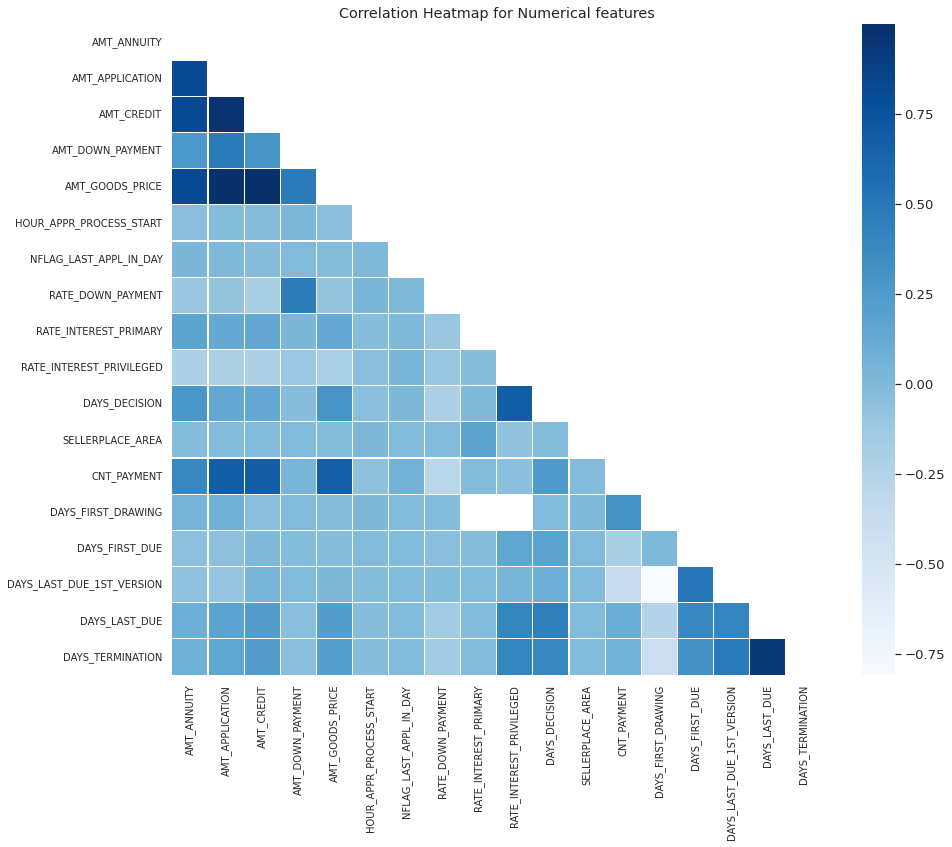

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (14,12))
corr_mat.plot_correlation_matrix()

In [ ]:
#Seeing the top columns with highest phik-correlation with the target variable in previous_applications table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

,Column Name,Phik-Correlation
12,CNT_PAYMENT,0.056639
10,DAYS_DECISION,0.053694
13,DAYS_FIRST_DRAWING,0.048993
7,RATE_DOWN_PAYMENT,0.039592
5,HOUR_APPR_PROCESS_START,0.038121
9,RATE_INTEREST_PRIVILEGED,0.028204
15,DAYS_LAST_DUE_1ST_VERSION,0.027878
16,DAYS_LAST_DUE,0.027320
17,DAYS_TERMINATION,0.026479
0,AMT_ANNUITY,0.013808


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
1. The heatmap above shows the correlation between each feature in previous_application table with the rest of the features.
2. From the heatmap, we can see some highly correlated features which have a darker colour.
3. The high correlation is particularly observed for features:
    - DAYS_TERMINATION and DAYS_LAST_DUE
    - AMT_CREDIT and AMT_APPLICATION
    - AMT_APPLICATION and AMT_GOODS_PRICE
    - AMT_CREDIT and AMT_ANNUITY
    - AMT_ANNUITY and AMT_CREDIT
    - AMT_CREDIT and AMT_GOODS_PRICE
4. We can also see that the features don't particularly show good/high correlation with Target as such. This implies that there isn't much of a direct linear relation between Target and the features.

## Plotting Categorical Variables
Let us now plot some of the Categorical Variables of table previous_application and see how they impact the Target Variable.

###Distribution of Categorical Variable NAME_CONTRACT_TYPE

This column descibes the type of the Contract of the previous loan with the Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


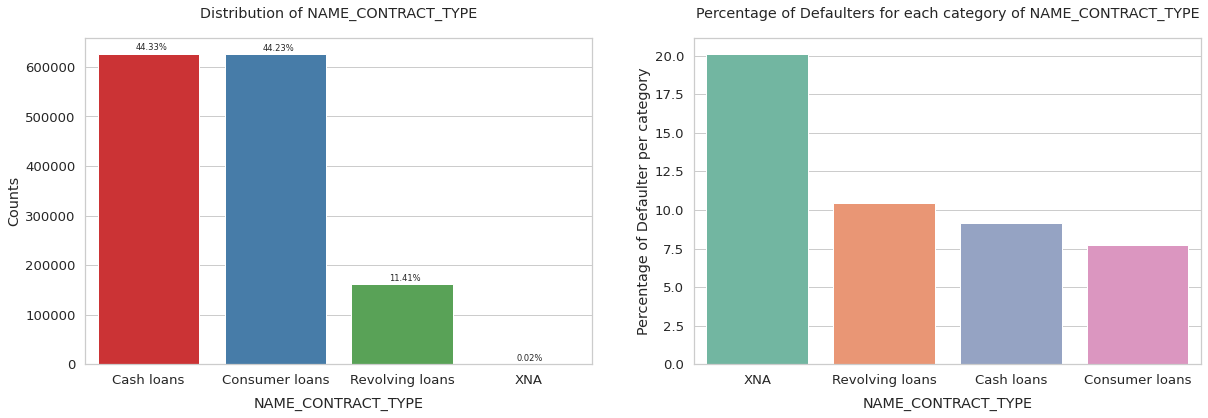

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

**Observations and Conclusions:**
From the above plots, we can observe the following:

1. From the first subplot, we see that most of the previous loans have been either Cash Loans or Consumer Loans, which correspond to roughly 44% of loans each. The remaining 11.41% corresponds to Revolving Loans, and there are some loans named XNA whose types are actually not known, but they are very few in numbers.
2. Looking at the second subplot, we see that the Percentage of Defaulters for XNA type of loan are the highest, at 20% Default rate. The next highest Default Rate is among Revolving Loans, which is close to 10.5%.
3. The Cash Loans have lesser default rates, roughly 9% while the consumer loans tend to have the lowest Percentage of Defaulters, which is close to 7.5%.

###Distribution of Categorical Variable NAME_CONTRACT_STATUS

This column describes the status of the contract of the previous loan with Home Credit, i.e. whether it is active or closed, etc

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


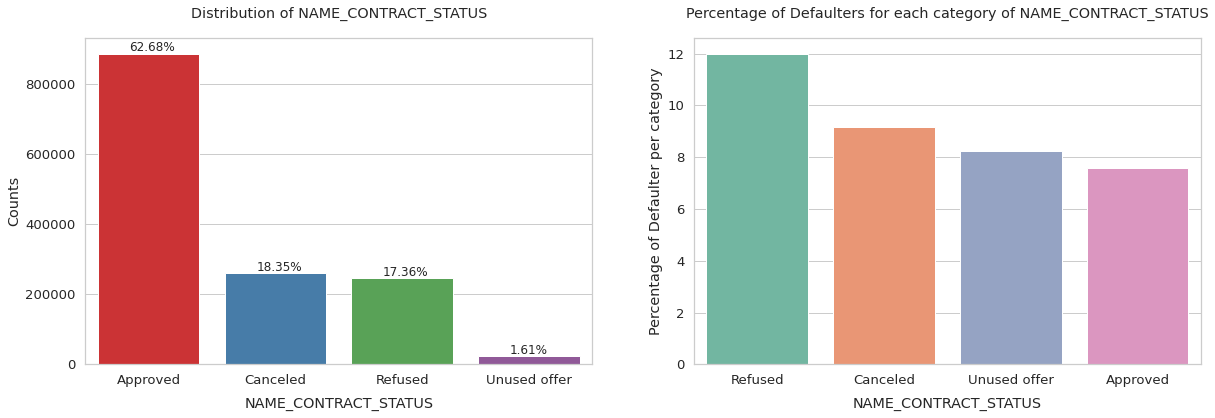

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

**Observations and Conclusions:**


From the above plots, we see that:

1. The most common type of Contract Status is the Approved Status. About 63% of the previous Credits have an Approved Status. The next two common status are Canceled and Refused, which both correspond to about 18% of the loans. This implies that most of the loans get approved and only some fraction of them do not. The least occurring type of contract status is Unused Offer which corresponds to just 1.61% of all the loans.
2. Looking at the second subplot for percentage of defaulters, we see that the those loans which previously had Refused Status tend to have defaulted the highest in the current loans. They correspond to about 12% of Defaulters from that category. These are followed by Canceled Status which correspond to close to 9% of Default Rate. This behavious is quite expected logically, as these people must have been refused due to not having adequate profile. The least default rate is observed for Contract Status of Approved.

###Distribution of Categorical Variable CODE_REJECT_REASON

This column describes the reason of the rejection of previously applied loan in Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------
Counts of each category are:
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CODE_REJECT_REASON = 10


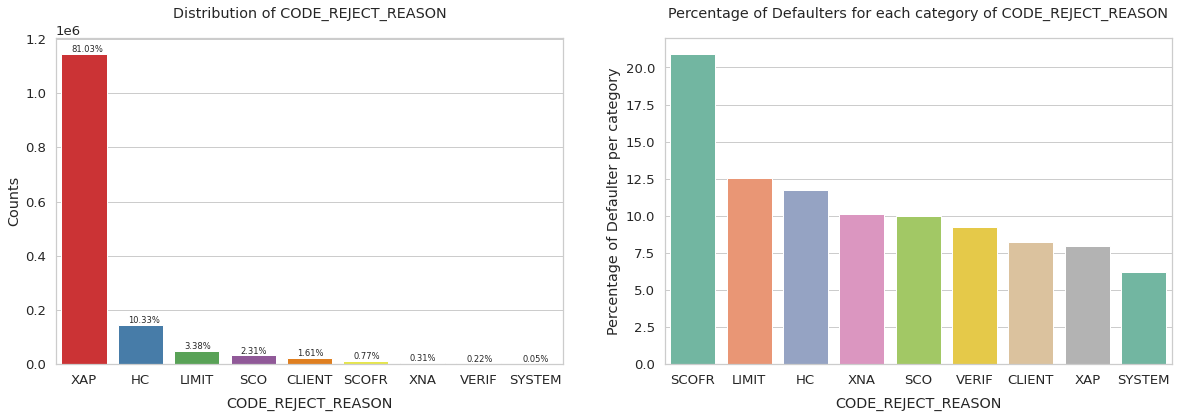

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.18, figsize = (20, 6))
print('-'*100)

**Observations and Conclusions:**

The above plot shows the distribution of the Categorical variable CODE_REJECT_REASON. Following insights can be generated from the above plot:

1. The most common type of reason of rejection is XAP, which is about ~81%. The other reasons form only a small part of the rejection reasons. HC is the second highest rejection reason with just 10.33% of occurrences.
2. The distribution of percentage of defaulters for each category of CODE_REJECT_REASON in quite interesting. Those applicants who had their previous applications rejected by Code SCOFT have the highest percentage of Defaulters among them (~21%). This is followed by LIMIT and HC which have around 12.5% and 12% of Defaulters.
3. The most common occurring rejection reason XAP corresponds to only 7.5% of Defaulters of all, and is the second lowest percentage of Defaulters after SYSTEM code.

###Distribution of Categorical Variable CHANNEL_TYPE

This column describes the channel through which the client was acquired for the previous loan in Home Credit.

----------------------------------------------------------------------------------------------------
The unique categories of 'CHANNEL_TYPE' are:
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CHANNEL_TYPE = 9


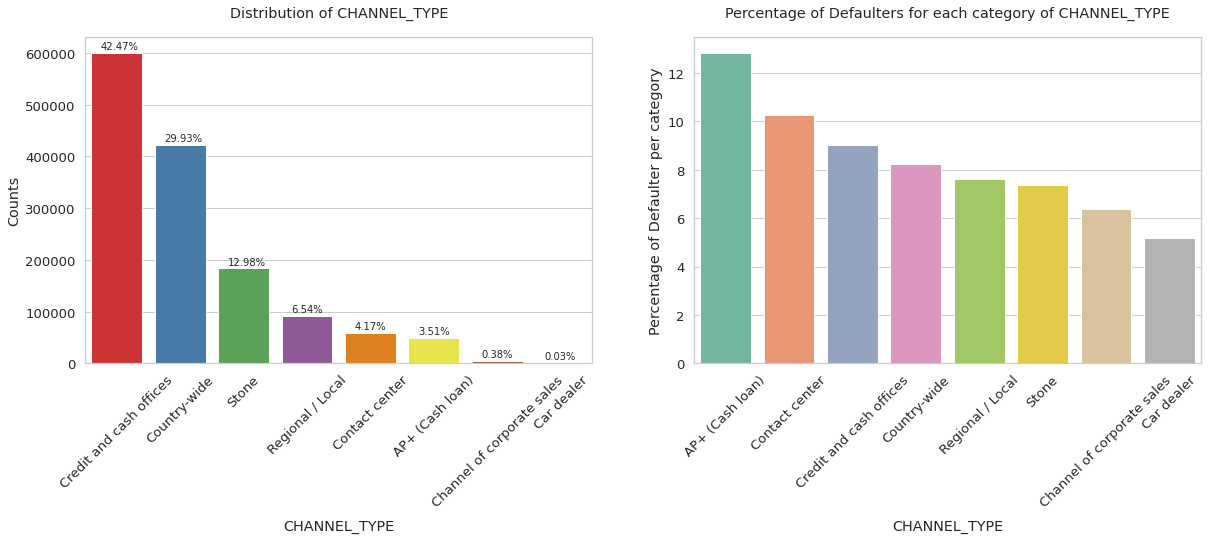

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'CHANNEL_TYPE'
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust = 0.15, rotation = 45, figsize = (20, 6), fontsize_percent = 'x-small')
print('-'*100)

**Observations and Conclusions**

The above two plots show the distribution of CHANNEL_TYPE for previous loans in Home Credit.

1. From the first subplot we see that most of the applications were acquired through the Credit and cash offices which were roughly 42.47% applications, which were followed by Country-wide channel corresponding to 29.93% applications. Rest of the channel types corresponded to only a select number of applications.
2. The highest Defaulting Percentage was seen among applications who had a channel type of AP+ (Cash loan) which corresponded to about 13% defaulters in that category. The rest of the channels had lower default percentages than this one. The channel Car Dealer showed a lowest Percentage of Defaulters in that category (only 5%).

###Distribution of Categorical Variable PRODUCT_COMBINATION

This column gives details about the product combination of the previous applications.

----------------------------------------------------------------------------------------------------
The unique categories of 'PRODUCT_COMBINATION' are:
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of PRODUCT_COMBINATION = 18


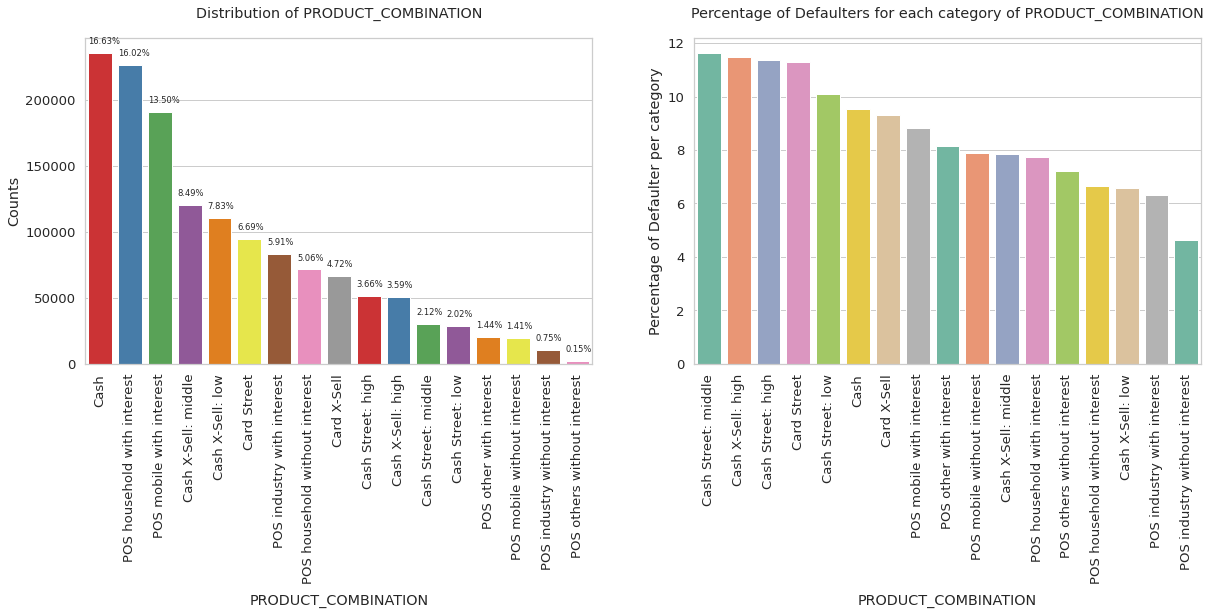

----------------------------------------------------------------------------------------------------


In [ ]:
#let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', rotation = 90, figsize = (20, 6))
print('-'*100)

**Observations and Conclusions**

From the distribution of PRODUCT_COMBINATION, we can generate following insights:

1. The 3 most common types of Product Combination are Cash, POS household with interest and POS mobile with interest. They correspond to roughly 50% of all the applications.
2. Looking at the Percentage of Defaulters per category plot, we see a highest defaulting tendency among Cash Street: mobile category, Cash X-sell: high, Cash Street: high and Card Street which all are near about 11-11.5% defaulters per category. The lowest Percentage of Defaulters are in the POS Industry without interest Category, which correspond to about 4.5% Defaulters.

## Plotting Continuous Variables

###Distribution of Continuous Variable with DAYS Features

### DAYS_DECISION

This column tells about the number of days relative to the current application when the decision was made about previous application.

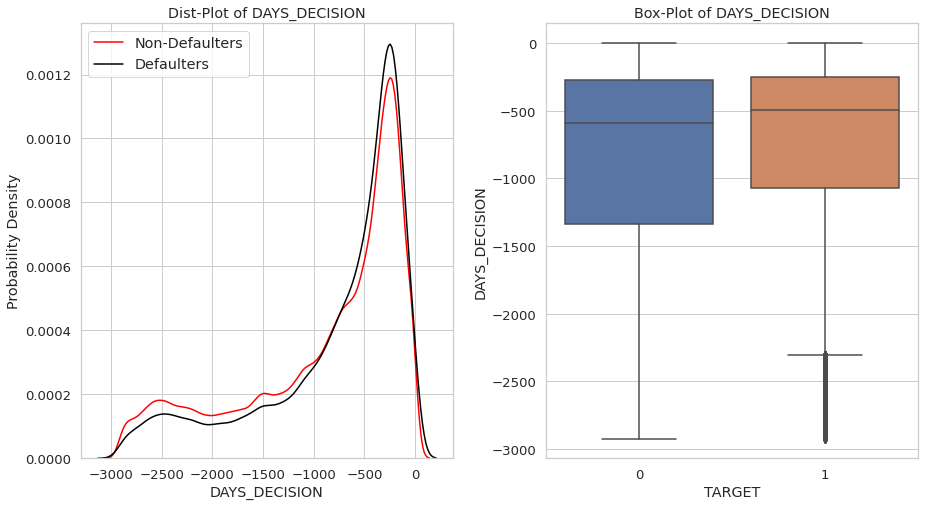

In [ ]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8))

**Observations and Conclusions**

From the above plot, we notice that for Defaulters, the number of days back when the decision was made is a bit lesser than that for Non-Defaulters. This implies that the Defaulters usually had the decision on their previous applications made more recently as compared to Non-Defaulters.

### DAYS_FIRST_DRAWING

This column tells about the number of days back from current application that the first disbursement of the previous application was made.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DRAWING is -2922.0
The 1th percentile value of DAYS_FIRST_DRAWING is -2451.0
The 2th percentile value of DAYS_FIRST_DRAWING is -1179.0
The 3th percentile value of DAYS_FIRST_DRAWING is -674.0
The 4th percentile value of DAYS_FIRST_DRAWING is -406.0
The 5th percentile value of DAYS_FIRST_DRAWING is -262.0
The 6th percentile value of DAYS_FIRST_DRAWING is -156.0
The 7th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 8th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 9th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 10th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 20th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 40th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 60th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 80th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 100th percentile

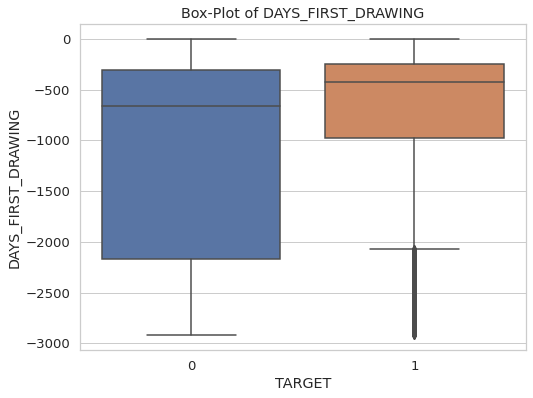

----------------------------------------------------------------------------------------------------


In [ ]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING', percentiles = list(range(0,11)) + list(range(20,101,20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (8,6), scale_limits = [-3000,0])
print('-'*100)

**Observations and Conclusions:**
1. Looking at the percentile values of DAYS_FIRST_DRAWING, it seems like most of the values are erroneous, starting from 7th percentile values itself. These erroneous values will needed to be dopped.
2. If we try to analyze the distribution of this column by removing the erroneous ponts, we see that most of the Defaulters had their First Drawing on previous credit more recently as compared to Non-Defaulters. The 75th percentile value for Defaulters is also significantly lesser than that of Non-Defaulters.

DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION

These columns also decribe about the number of days ago from the current application that certain activities happened.

In [ ]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DUE is -2892.0
The 2th percentile value of DAYS_FIRST_DUE is -2759.0
The 4th percentile value of DAYS_FIRST_DUE is -2648.0
The 6th percentile value of DAYS_FIRST_DUE is -2555.0
The 8th percentile value of DAYS_FIRST_DUE is -2471.0
The 10th percentile value of DAYS_FIRST_DUE is -2388.0
The 20th percentile value of DAYS_FIRST_DUE is -1882.0
The 40th percentile value of DAYS_FIRST_DUE is -1070.0
The 60th percentile value of DAYS_FIRST_DUE is -647.0
The 80th percentile value of DAYS_FIRST_DUE is -329.0
The 100th percentile value of DAYS_FIRST_DUE is 365243.0
----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
------------

**Observations and Conclusions**

From all of the above percentile values, we realise that all the Days columns have these erroneous values somewhere or the other. Thus these values need to be replaced so that our model doesn't get affected by these.

#installments_payments.csv

**Description**

This table lists out the repayment history of each of the loan that the applicant had with Home Credit Group. The table contains features like the amount of instalment, how much did the client pay for each instalments, etc.

In [ ]:

ins = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/installments_payments.csv')


print(f'The shape of installments_payments.csv is: {ins.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(ins.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(ins.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(ins.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(test.SK_ID_CURR.unique()).intersection(set(ins.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in installments_payments: {ins.shape[0] - ins.duplicated().shape[0]}')
print('-'*100)
display(ins.head(5))

The shape of installments_payments.csv is: (13605401, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 997752
Number of unique SK_ID_CURR in installments_payments.csv are: 339587
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 291643
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 47944
----------------------------------------------------------------------------------------------------
Number of duplicate values in installments_payments: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


**Observations and Conclusions**
1. There are about 13.6M datapoints in the table installments_payments.csv. Each row represents each installment history related to the a particular loan that the client previously had with Home Credit Group.
2. There are 997k unique previous loans in the installments_payments. These belong to 339k unique SK_ID_CURR, which are ID of applicants of current loan.
3. Out of these 339k SK_ID_CURR, 291k belong to the training dataset, and 47.9k belong to the test dataset. This implies that almost out of 307k unique SK_ID_CURR in application_train, 291k previously had some form of loan with Home Credit. Similarly for 48.7k of those in test dataset, 47.9k had loan previously with Home Credit.
4. The table has 8 unique features, 6 of which describe the statistics of each installment for previous loan.

###NaN Columns and Percentages

In [ ]:
print('-'*100)
print("Columns with NaN values and their percentages:")
ins_nan = nan_df_create(ins)
display(ins_nan[ins_nan.percent != 0])
print('-'*100)
del ins_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
5,DAYS_ENTRY_PAYMENT,0.021352
7,AMT_PAYMENT,0.021352


----------------------------------------------------------------------------------------------------


**Observations and Conclusions**
1. here are only 2 columns which contain NaN values of the 8 columns from installments_payments.
2. These columns also contain very minimal proportion of NaN values, i.e only 0.02%, so it is not of much concern.

###Merging the TARGETS from application_train to installments_payments table

In [ ]:
print("-"*100)
print("Merging TARGET with installments_payments Table")
ins_merged = train.iloc[:,:2].merge(ins, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with installments_payments Table
----------------------------------------------------------------------------------------------------


###Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


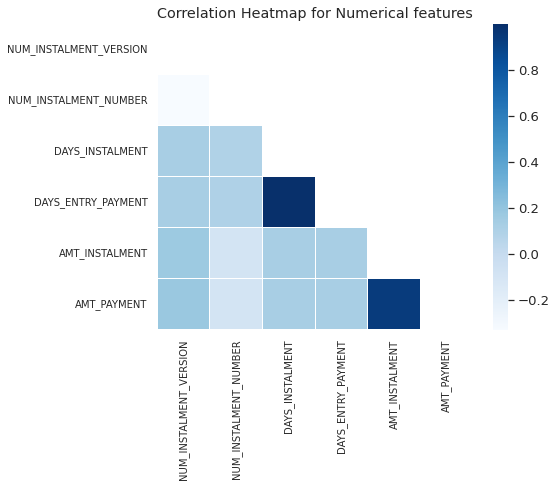

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(ins_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat.plot_correlation_matrix()

In [ ]:
 #Seeing the top columns with highest phik-correlation with the target variable in installments_payments table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
2,DAYS_INSTALMENT,0.046824
3,DAYS_ENTRY_PAYMENT,0.033128
1,NUM_INSTALMENT_NUMBER,0.022993
4,AMT_INSTALMENT,0.004125
5,AMT_PAYMENT,0.003084
0,NUM_INSTALMENT_VERSION,0.002198


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
1. The heatmap above shows the correlation between each feature in installments_payments table with the rest of the features.
2. From the heatmap of correlation matrix, we see a couple of highly correlated features. These are:
    - AMT_INSTALMENT and AMT_PAYMENT
    - DAYS_INSTALMENT and DAYS_ENTRY_PAYMENT
3. These two sets of correlated features are understandable, as they are actually the features as to when the installment was due to be paid vs when it was paid and also the amount that was due vs the amount that was paid.
4. These features will be useful for creating new sets of completely uncorrelated features.
5. The correlation of features with Target isn't noticeable, this shows the absence of a linear relationship between the feature and the target variable.

###Plotting Continuous Variables

Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
ins_merged = ins_merged.groupby('SK_ID_PREV').mean()

####Distribution of Continuous Variable DAYS_INSTALMENT

This column lists the days when the installment of previous credit was to be paid

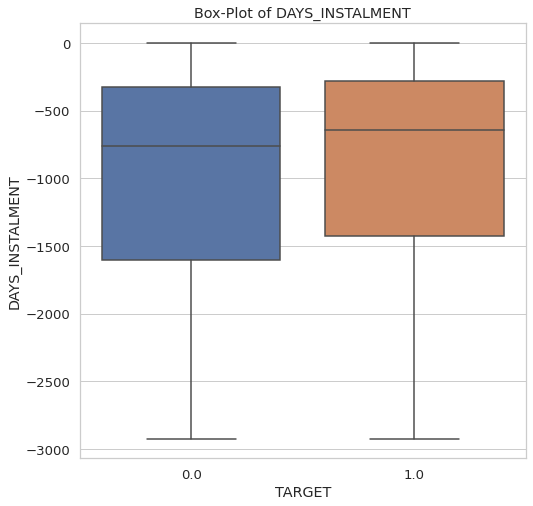

In [ ]:
plot_continuous_variables(ins_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

####Distribution of Continuous Vairable DAYS_ENTRY_PAYMENT

This column lists the days when the installment of previous credit was actually paid

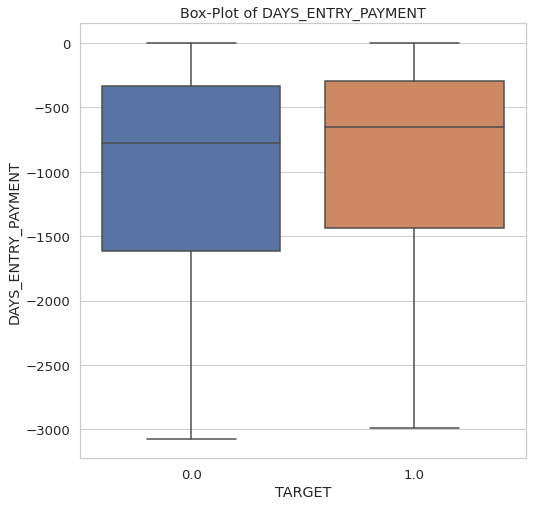

In [ ]:
plot_continuous_variables(ins_merged, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
del ins_merged

**Observations and Conclusions**


From the above two plots, we can see a similar pattern, where the Defaulters tend to have lesser number of days since their last payment, while Non-Defaulters have more number of days since their last payments. All quantiles of Defaulters have more recent days than those of Non-Defaulters. Thus, Non-Defaulters usually have more gap in their payments from the day of application as compared to Defaulters.

#POS_CASH_balance.csv

**Description**

This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group. The table contains columns like the status of contract, the number of installments left, etc.

In [ ]:

pos = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/POS_CASH_balance.csv')

print(f'The shape of POS_CASH_balance.csv is: {pos.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(pos.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(pos.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(pos.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: {len(set(test.SK_ID_CURR.unique()).intersection(set(pos.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in POS_CASH_balance: {pos.shape[0] - pos.duplicated().shape[0]}')
print('-'*100)
display(pos.head())

The shape of POS_CASH_balance.csv is: (10001358, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 289444
Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: 47808
----------------------------------------------------------------------------------------------------
Number of duplicate values in POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


**Observations and Conclusions**

1. This table contains around 10M datapoints, where each row corresponds to the monthly snapshot of the status of the previous POS and Cash Loan that the client had with Home Credit Group. It consists of 8 columns, two of which are SK_ID_CURR and SK_ID_PREV.
2. There are 936k unique previous loan IDs in the table, which correspond to 337k unique current applicants (SK_ID_CURR).
3. Out of these 337k SK_ID_CURR, 289k belong to training set and 47.8k belong to test set.

### NaN Columns and Percentages

In [ ]:
print('-'*100)
print("Columns with NaN values and their percentages:")
pos_nan = nan_df_create(pos)
display(pos_nan[pos_nan.percent != 0])
print('-'*100)
del pos_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
4,CNT_INSTALMENT_FUTURE,0.260835
3,CNT_INSTALMENT,0.260675


----------------------------------------------------------------------------------------------------


**Observations and Conclusions**
1. There are only 2 columns which contain NaN values of the 8 columns from POS_CASH_balance. These columns are the Counts of Installments remaining and the term of the loan.
2. These columns also contain very minimal proportion of NaN values, i.e only 0.26%%, so it is also not of much concern.

####Merging the TARGETS from application_train to POS_CASH_balance table

In [ ]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_merged = train.iloc[:,:2].merge(pos, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


###Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


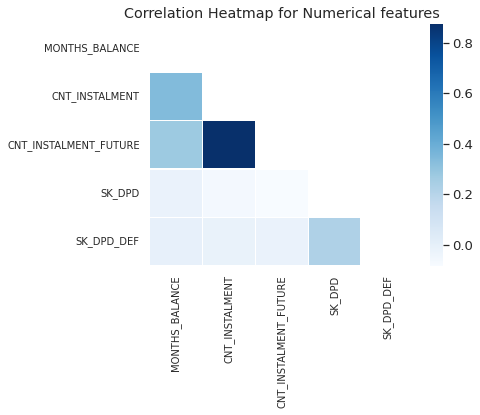

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(pos_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

In [ ]:
#Seeing the top columns with highest phik-correlation with the target variable in POS_CASH_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
2,CNT_INSTALMENT_FUTURE,0.033194
1,CNT_INSTALMENT,0.030947
0,MONTHS_BALANCE,0.027391
3,SK_DPD,0.012773
4,SK_DPD_DEF,0.010539


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
1. The above heatmap shows the correlation between the fetures
2. From the heatmap of correlation matrix, we one set of moderately correlated features, which are: CNT_INSTALMENT and CNT_INSTALMENT_FUTURE.
3. The correlation of features with Target is very low, this shows the absence of a linear relationship between the feature and the target variable.

###Plotting Continuous Variables

Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
pos_merged = pos_merged.groupby('SK_ID_PREV').mean()

####Distribution of Continuous Variable CNT_INSTALMENT_FUTURE

This column describes the number of installments left to pay on the previous credit

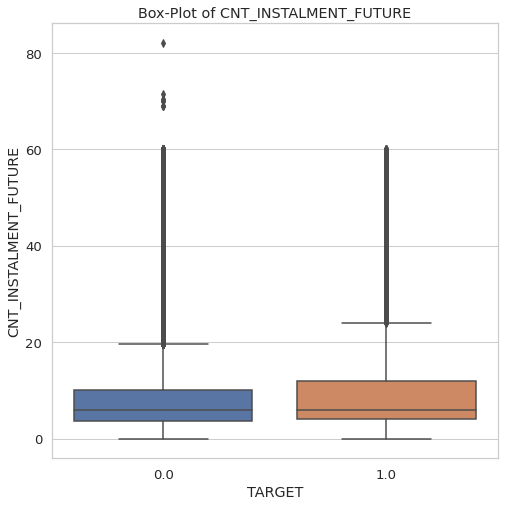

In [ ]:
plot_continuous_variables(pos_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_merged

**Observations and Conclusions**

Looking at the above box-plot for CNT_INSTALMENT_FUTURE, we see that the percentile values>50% for Defaulters are usually higher than those of Non-Defaulters. Even the upper limit whisker for Defaulters is higher than that of Non-Defaulters. This suggests that the Defaulters tend to have more number of Installments remaining on their previous credits as compared to Non-Defaulters

#credit_card_balance.csv

**Description**

This table consists of the monthly data related to any or multiple Credit Cards that the applicant had with the Home Credit Group. The table contains fields like balance, the credit limit, amount of drawings, etc. for each month of the credit card.

In [ ]:

cc = pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/credit_card_balance.csv')

print(f'The shape of credit_card_balance.csv is: {cc.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(cc.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(cc.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(cc.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(test.SK_ID_CURR.unique()).intersection(set(cc.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Number of duplicate values in credit_card_balance: {cc.shape[0] - cc.duplicated().shape[0]}')
print('-'*100)
display(cc.head(5))

The shape of credit_card_balance.csv is: (3840312, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


**Observations and Conclusions**
1. There are around 3.84M rows in the table credit_card_balance.csv, each of which corresponds to the monthly status of the Credit Card which the applicant had with Home Credit Group. This table contains 23 features which contain the statistics about each month's Credit Card status, such as Balance amount, Amount of Drawings, Number of drawings, status, etc.
2. There are 104.3k unique Credit Cards whose details are in this table.
3. Out of these 104.3k there are 103.5k unique SK_ID_CURR. What this means is that most of the applicants had just 1 credit card with them, and only few of them had more than 1. These SK_ID_CURR are the ID of the applicants who have currently applied for loan.
4. Out of the 103k unique SK_ID_CURR, 86.9k of these applicants belong to the training set, and 16.6k belong to test application set.
5. Out of 307k applicants in application_train table, only 86.9k of those had a credit card previously with Home Credit Group.

### NaN Columns and Percentages

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


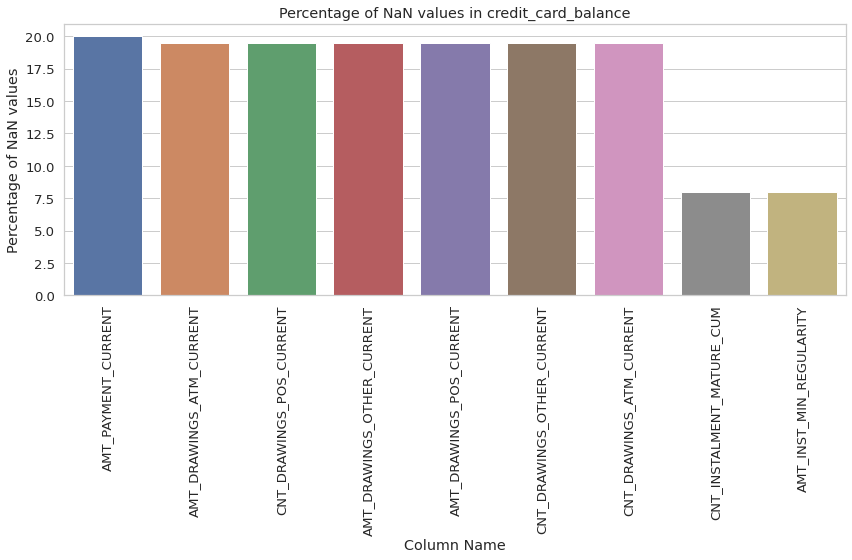

----------------------------------------------------------------------------------------------------


In [ ]:
cc_nan = nan_df_create(cc)
print('-'*100)
plot_nan_percent(cc_nan, 'credit_card_balance', tight_layout = False, rotation = 90, figsize = (14,5))
print('-'*100)
del cc_nan

**Observation and Conclusions**
1. Out of the 23 features, 9 of these features contain some NaN values.
2. If we look at the percentages of NaN values, they are considerably lower than the rest of the tables we have seen so far.
3. 7 of these features have close to 20% NaN values. These features are mostly related to the Amounts of Drawing and Counts of Drawings. Other two of the features are related to the installments statistics.

#### Merging the TARGETS from application_train to credit_card_balance table

In [ ]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
cc_merged = train.iloc[:,:2].merge(cc, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


###Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


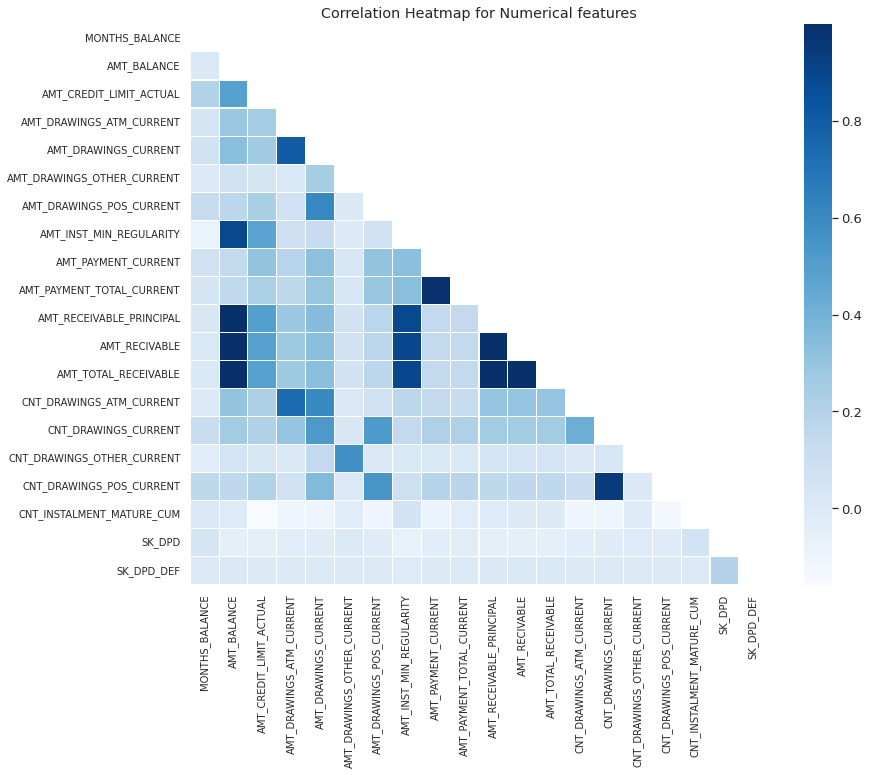

----------------------------------------------------------------------------------------------------


In [ ]:
corr_mat = correlation_matrix(cc_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

In [ ]:
#Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

,Column Name,Phik-Correlation
1,AMT_BALANCE,0.059838
11,AMT_RECIVABLE,0.059311
12,AMT_TOTAL_RECEIVABLE,0.059287
10,AMT_RECEIVABLE_PRINCIPAL,0.058895
0,MONTHS_BALANCE,0.050360
7,AMT_INST_MIN_REGULARITY,0.042174
17,CNT_INSTALMENT_MATURE_CUM,0.038261
13,CNT_DRAWINGS_ATM_CURRENT,0.030052
2,AMT_CREDIT_LIMIT_ACTUAL,0.028752
14,CNT_DRAWINGS_CURRENT,0.027868


----------------------------------------------------------------------------------------------------


**Observations and Conclusions:**
1. The heatmap above shows visually the correlation among features in credit_card_balance table.
2. From the heatmap of correlation matrix, we see a few couples of highly correlated features. These are:
    - AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE and AMT_BALANCE
    - We also observe high correlation between these 3 AMT_RECEIVABLE columns
    - AMT_PAYMENT_TOTAL_CURRENT and AMT_PAYMENT_CURRENT
3. The sets of 2nd and 3rd correlating features are understandable because they more or less the same tale.
4. The correlation of features with Target isn't noticeable, this shows the absence of a linear relationship between the feature and the target variable.

####Plotting Continuous Variables


Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [ ]:
cc_merged = cc_merged.groupby('SK_ID_PREV').mean()

####Distribution of Continuous Vairable AMT_BALANCE

This column provided the average amount of balance that a person usually had on his credit card loan account for previous loan.

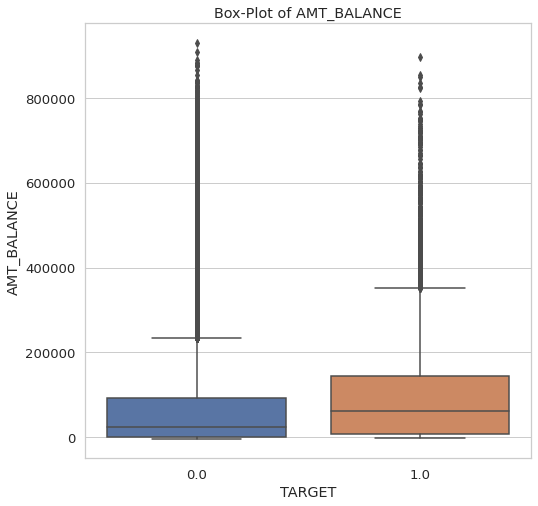

In [ ]:
plot_continuous_variables(cc_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

**Observations and Conclusions**

From the above plot, it can be seen that the Defaulters have a higher value of AMT_BALANCE as compared to Non-Defaulters. They show a higher values of all the quantiles and even the whiskers. This could imply that the Credit amount for Defaulters could also be relatively higher as compared to Non-Defaulters.

**Observations and Conclusions:**

We see that the Defaulters here too appeared to have a higher minimum installment each month as compared to Non-Defaulters. This usually tells about the spending and borrowing habbit of the people. The defaulters show a higher spending and borrowing habits as compared to Non-Defaulters.

####Distribution of Continuous Variable AMT_TOTAL_RECEIVABLE

This column describes the average of total amount receivable on the previous credit.

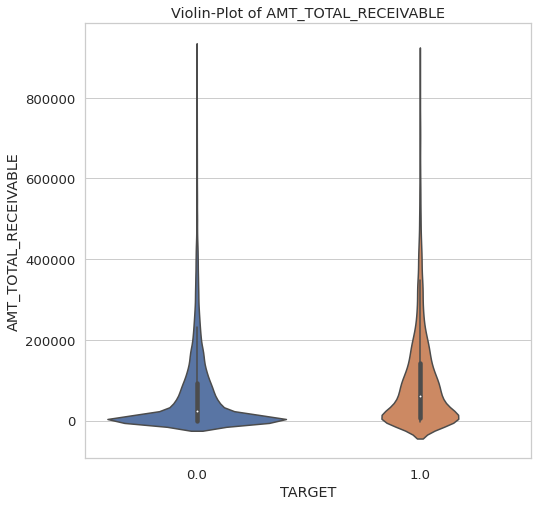

In [ ]:
plot_continuous_variables(cc_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

**Observations and Conclusions**

Looking at the box plot of AMT_TOTAL_RECEIVABLE, we see a similar behavious as seen with other amounts as well, which is that the Defaulters usually had higher Amount Receivable on their previous credit, which may imply the higher amounts of credits that they may have taken. The PDF also shows a very higher peak at lower amounts for Non-Defaulters as compared to Defaulters.

####Distribution of Continuous Variable CNT_INSTALMENT_MATURE_CUM

The column describes about the average number of installments paid on the previous credits.

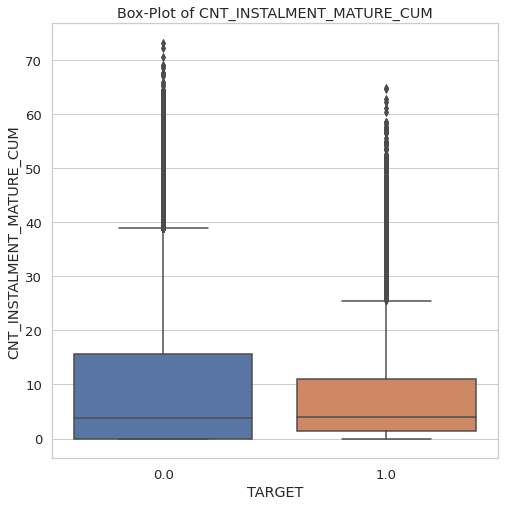

In [ ]:
plot_continuous_variables(cc_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

**Observations and Conclusions**

From the above plot, we see a very interesting behaviour. This plot shows that the Non-Defaulters usually had higher range of values for the number of installments paid as compared to Defaulters. This might show the defaulting behaviour, where in the defaulters usually would pay fewer number of installments on their previous credit.